# Notebook 2 - Generative models of extra-cellular spike recordings


## Part 1 - Spike recordings and basic machine learning analysis

## Part 1.1 - Dataset overview

Info about the dataset: https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels

Summary as a youtube video (2016): https://www.youtube.com/watch?v=WXjstSdpv74

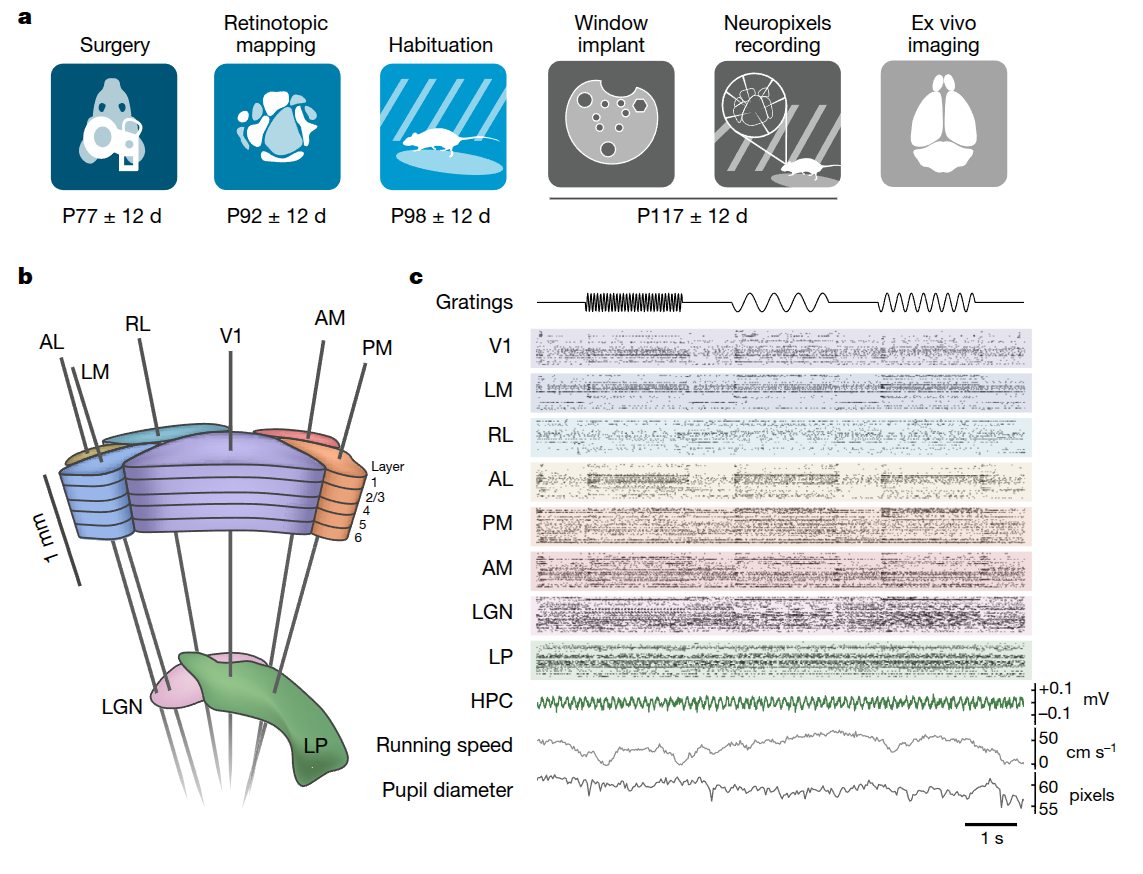





In [1]:
!pip install numpy==1.23.5, "zarr<3", scipy==1.10.1 torch # Numerical python and downgrade zarr because it makes compatibility issues with numpy 1.23
!pip install allensdk #==2.16.2 # Allen Institute data to load the data

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached zarr-2.18.7-py3-none-any.whl.metadata (5.8 kB)
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached asciitree-0.3.3-py3-none-any.whl
INFO: pip is looking at multiple versions of zarr to determine which version is compatible with other requirements. This could take a while.
  Using cached zarr-2.18.6-py3-none-any.whl.metadata (5.8 kB)
  Using cached zarr-2.18.5-py3-none-any.whl.metadata (5.8 kB)
  Using cached zarr-2.18.4-py3-none-any.whl.metadata (5.8 kB)
  Using cached zarr-2.18.3-py3-none-any.whl.metadata (5.7 kB)
  Using cached zarr-2.18.2-py3-none-any.whl.metadata (5.7 kB)
  Using cached fasteners-0.20-py3-none-any.whl.metadata (4.8 kB)
INFO: pip is looking at multiple versions of numcodecs to determine which version is compatible with other requirements. This could take a while.
  Using cached numc

In [2]:
# Package imports
import sys
import os
import matplotlib.pyplot as plt

home = os.environ["HOME"]
python_imports = f"{home}/shared/DLN-2025W/notebook-2"
cache_root = f"{home}/shared/DLN-2025W/notebook-2/"
sys.path.append(python_imports)


In [3]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


/opt/micromamba/lib/python3.11/site-packages/allensdk/core/brain_observatory_nwb_data_set.py:43: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


Init AllenToTensor sessions_id 791319847 stimulus drifting_gratings
Created AllenToTensor for session: 791319847
Loaded 'raster.npy' from cache, size: 63.0857 Mb
Loaded 'unit_indices_all_areas.pickle' from cache, size: 0.0040 Mb
Loaded 'unit_indices_all_areas.pickle' from cache, size: 0.0040 Mb
Loaded 'unit_indices_signs_and_waveforms_data_all.pickle' from cache, size: 0.0001 Mb
Loaded 'behavior.pickle' from cache, size: 0.0001 Mb
Loaded 'time_line.npy' from cache, size: 0.9614 Mb
Loaded 'trial_condition_vector_stimulus_condition_id.npy' from cache, size: 0.0049 Mb
Loaded 'trial_condition_vector_stimulus_condition_id.npy' from cache, size: 0.0049 Mb
(416, 200, 525)


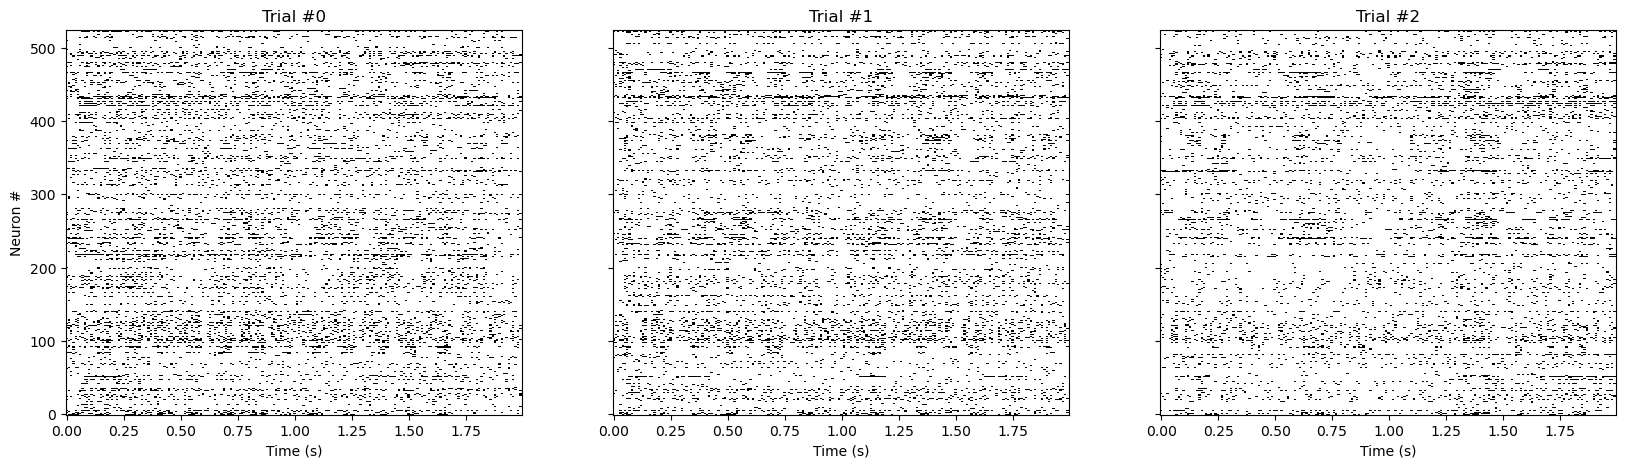

In [4]:
from allen_to_tensor import AllenToTensor
from allen_dataset import AllenDriftingDataset

# Build Allen Institute neuropixels dataset wrapper.
# Make spike raster plot with time step binning of 10ms
# We only consider a single session (1~3 hours of recordings)
dataset = AllenDriftingDataset(train_fraction=0.66, dt=0.01, cache_root=cache_root)

# load raster plots
z_train = dataset.get_rasters("train", 0,)
z_test = dataset.get_rasters("test", 0,)
B, T, N = z_train.shape

print(z_train.shape)

time_line = np.arange(T) * dataset.dt
neuron_range = np.arange(N)
fig,ax_list = plt.subplots(1,3, sharey=True, sharex=True, figsize=(20,5))

for i in range(len(ax_list)):
    ax = ax_list[i]
    ax.pcolor(time_line, neuron_range, z_train[i].T, cmap="Greys")
    ax.set_title(f"Trial #{i}")
    ax.set_xlabel("Time (s)")
    if i == 0: ax.set_ylabel("Neuron #")


Each trial corresponds to a different drifting grating stimulus

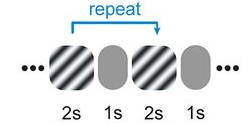

In [5]:
conditions = dataset.list_of_conditions
condition_specs = dataset.get_condition_specs()

for i in range(len(ax_list)):
    print(f"Trial #{i}, condition specs: \n\t", condition_specs[conditions[i]])


Loaded 'drifting_condition_spec_dict.pickle' from cache, size: 0.0011 Mb
Trial #0, condition specs: 
	 {'stimulus_condition_id': 246, 'orientation': '90.0', 'contrast': '0.8', 'temporal_frequency': '15.0'}
Trial #1, condition specs: 
	 {'stimulus_condition_id': 247, 'orientation': '135.0', 'contrast': '0.8', 'temporal_frequency': '4.0'}
Trial #2, condition specs: 
	 {'stimulus_condition_id': 248, 'orientation': '135.0', 'contrast': '0.8', 'temporal_frequency': '2.0'}


In [6]:
dataset.trial_to_condition_list

[array([246, 247, 248, 249, 250, 246, 251, 252, 253, 254, 255, 256, 257,
        246, 258, 259, 260, 261, 262, 261, 251, 263, 264, 264, 265, 250,
        266, 267, 268, 269, 257, 261, 270, 254, 271, 254, 272, 249, 256,
        246, 273, 247, 252, 270, 271, 274, 257, 250, 268, 252, 270, 275,
        264, 276, 277, 267, 276, 267, 264, 278, 276, 261, 247, 251, 247,
        278, 279, 260, 274, 258, 246, 269, 269, 280, 281, 282, 263, 282,
        279, 281, 254, 283, 284, 257, 266, 274, 246, 256, 248, 268, 272,
        275, 281, 279, 280, 285, 250, 285, 277, 259, 251, 249, 256, 270,
        265, 269, 254, 284, 267, 266, 281, 248, 267, 255, 273, 272, 260,
        264, 265, 276, 280, 272, 267, 280, 250, 264, 282, 280, 275, 283,
        248, 283, 282, 278, 273, 257, 256, 267, 262, 271, 280, 257, 252,
        258, 284, 267, 275, 271, 258, 269, 247, 281, 247, 253, 263, 276,
        253, 284, 268, 264, 275, 271, 283, 284, 285, 258, 283, 262, 256,
        265, 254, 264, 274, 279, 259, 279, 260, 262

In [7]:
ori_value_list = ['null', '0.0', '45.0', '90.0', '135.0', '180.0', '225.0', '270.0', '315.0']
ori_int_labels, values = dataset.make_condition_labels("orientation", label_value_list= ori_value_list)
rasters = dataset.raster_list
print(f"labels: {ori_int_labels[0][:20]}")
print(f"values: {values}")
print(f"raster shapes: {[l.shape for l in ori_int_labels]}")
print(f"raster shapes: {[r.shape for r in rasters]}")

Loaded 'drifting_condition_spec_dict.pickle' from cache, size: 0.0011 Mb
labels: [3 4 4 1 6 3 6 8 6 7 7 8 0 3 3 3 7 5 7 5]
values: ['null', '0.0', '45.0', '90.0', '135.0', '180.0', '225.0', '270.0', '315.0']
raster shapes: [(630,)]
raster shapes: [(630, 200, 525)]


In [8]:
unit_list = dataset.recording_unit_ids_list[0]
AtoT = dataset.allen_to_tensor_list[0]

area_dict = AtoT.compute_dict_of_unit_ids_per_area()
area_unit_count = dict([(k,len(v)) for k,v in area_dict.items()])

print("Counting number of units (aka. putative neurons) per areas:")
area_unit_count


Loaded 'unit_indices_VISp.pickle' from cache, size: 0.0007 Mb
Loaded 'unit_indices_VISrl.pickle' from cache, size: 0.0005 Mb
Loaded 'unit_indices_VISl.pickle' from cache, size: 0.0005 Mb
Loaded 'unit_indices_VISal.pickle' from cache, size: 0.0004 Mb
Loaded 'unit_indices_VISpm.pickle' from cache, size: 0.0002 Mb
Loaded 'unit_indices_VISam.pickle' from cache, size: 0.0004 Mb
Loaded 'unit_indices_CA1.pickle' from cache, size: 0.0007 Mb
Loaded 'unit_indices_CA3.pickle' from cache, size: 0.0003 Mb
Loaded 'unit_indices_DG.pickle' from cache, size: 0.0003 Mb
Loaded 'unit_indices_SUB.pickle' from cache, size: 0.0003 Mb
Loaded 'unit_indices_ProS.pickle' from cache, size: 0.0000 Mb
Loaded 'unit_indices_LGd.pickle' from cache, size: 0.0001 Mb
Loaded 'unit_indices_LP.pickle' from cache, size: 0.0001 Mb
Loaded 'unit_indices_APN.pickle' from cache, size: 0.0000 Mb
Counting number of units (aka. putative neurons) per areas:


{'VISp': 93,
 'VISrl': 58,
 'VISl': 56,
 'VISal': 43,
 'VISpm': 17,
 'VISam': 49,
 'CA1': 85,
 'CA3': 33,
 'DG': 32,
 'SUB': 41,
 'ProS': 1,
 'LGd': 8,
 'LP': 9,
 'APN': 0}

## Part 1.2 - Linear Decoding analysis

We will train linear classifiers on the spike counts as first analysis of the data.
We train a different classifier for each area.

In [9]:
class Classifier(nn.Module):

    def __init__(self, num_units, num_classes):
        super(Classifier, self).__init__()
        self.num_units = num_units
        self.num_classes = num_classes
        self.linear = nn.Linear(num_units, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.loss = nn.CrossEntropyLoss()

    def accuracy(self, x, labels):
        self.eval()
        logits = self.linear(self.dropout(x))
        is_correct = logits.argmax(1).eq(labels).float()
        return is_correct.mean().item()

    def confusion_matrix(self, x, labels):
        self.eval()
        with torch.no_grad():
            if len(x.shape) == 3: x = x.mean(1)
            logits = self.linear(self.dropout(x))
            predictions = logits.argmax(1)

            # Create confusion matrix
            cm = torch.zeros(self.num_classes, self.num_classes, dtype=torch.long)
            for true_label, pred_label in zip(labels, predictions):
                cm[true_label, pred_label] += 1

            cm = cm.float() / cm.sum(0, keepdim=True).clip(min=1)

        return cm

    def forward(self, x, labels):
        if len(x.shape) == 3: x = x.mean(1)
        logits = self.linear(self.dropout(x))
        loss = self.loss(logits, labels)
        return loss

selected_areas = [k for k,v in area_dict.items() if len(v) >= 40]
classifier_dict = dict([a, Classifier(40,9)] for a in selected_areas)

confusion_mat_dict = {}
accuracy_dict = {}

train_indices = dataset.get_split_specific_trial_selection(0, "train")
test_indices = dataset.get_split_specific_trial_selection(0, "test")

ori_labels = dataset.make_condition_labels("orientation", label_value_list= ori_value_list)[0][0]

label_train = torch.tensor(ori_labels, dtype=torch.long)[train_indices]
label_test = torch.tensor(ori_labels, dtype=torch.long)[test_indices]

for area in selected_areas:
    print(f"\n\tarea={area}")
    inds = dataset.get_neuron_indices_for_area(area)[:40]


    # load data tensors
    x_train = torch.tensor(dataset.raster_list[0][train_indices]).float().mean(1)[..., inds]
    x_test = torch.tensor(dataset.raster_list[0][test_indices]).float().mean(1)[..., inds]

    C : Classifier = classifier_dict[area]
    C.train()
    optimizer = torch.optim.AdamW(C.parameters(), 0.01)

    for i in range(6000):
        C.zero_grad()
        loss = C(x_train, label_train)
        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            train_acc  = C.accuracy(x_train, label_train)
            test_acc = C.accuracy(x_test, label_test)
            print(f"loss={loss.item():0.03f} train_acc={train_acc:0.2f} test_acc={test_acc:0.2f}")

    accuracy_dict[area] = (train_acc, test_acc)
    confusion_mat_dict[area] = C.confusion_matrix(x_test, label_test)


Loaded 'drifting_condition_spec_dict.pickle' from cache, size: 0.0011 Mb

	area=VISp
Loaded 'unit_indices_VISp.pickle' from cache, size: 0.0007 Mb
Loaded 'unit_indices_VISrl.pickle' from cache, size: 0.0005 Mb
Loaded 'unit_indices_VISl.pickle' from cache, size: 0.0005 Mb
Loaded 'unit_indices_VISal.pickle' from cache, size: 0.0004 Mb
Loaded 'unit_indices_VISpm.pickle' from cache, size: 0.0002 Mb
Loaded 'unit_indices_VISam.pickle' from cache, size: 0.0004 Mb
Loaded 'unit_indices_CA1.pickle' from cache, size: 0.0007 Mb
Loaded 'unit_indices_CA3.pickle' from cache, size: 0.0003 Mb
Loaded 'unit_indices_DG.pickle' from cache, size: 0.0003 Mb
Loaded 'unit_indices_SUB.pickle' from cache, size: 0.0003 Mb
Loaded 'unit_indices_ProS.pickle' from cache, size: 0.0000 Mb
Loaded 'unit_indices_LGd.pickle' from cache, size: 0.0001 Mb
Loaded 'unit_indices_LP.pickle' from cache, size: 0.0001 Mb
Loaded 'unit_indices_APN.pickle' from cache, size: 0.0000 Mb
loss=2.196 train_acc=0.11 test_acc=0.09
loss=0.448 t

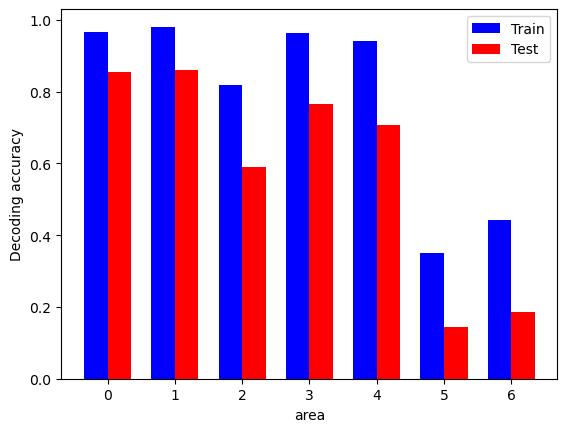

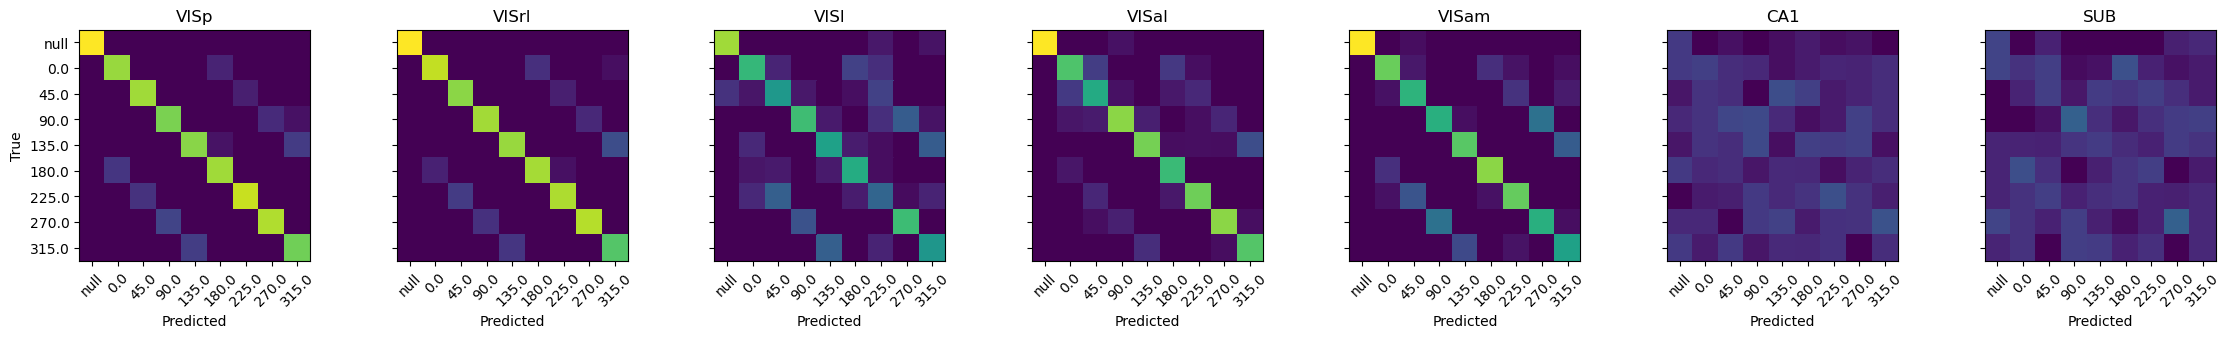

In [10]:
def accuracy_bar_plot(accuracy_dict):

    bar_labels = list(accuracy_dict.keys())
    train_accs = [acc_train for acc_train, acc_test in accuracy_dict.values()]
    test_accs = [acc_test for acc_train, acc_test in accuracy_dict.values()]  # Fixed: acc_test

    # Create numeric indices for bar positions
    bar_indices = np.arange(len(bar_labels))
    width = 0.35  # Width of bars

    # Create the grouped bar chart
    plt.bar(bar_indices - width/2, train_accs, width, label='Train', color='b')
    plt.bar(bar_indices + width/2, test_accs, width, label='Test', color='r')

    plt.ylabel("Decoding accuracy")
    plt.xlabel("area")
    plt.legend()
    plt.show()


def plot_confusion_matrices(confusion_mat_dict, label_value_list):


    pythonfig, ax_list = plt.subplots(1, len(selected_areas), sharex=True, sharey=True,
                                figsize=(4 * len(selected_areas), 3))

    for i, a in enumerate(selected_areas):
        # Plot confusion matrix
        im = ax_list[i].pcolor(confusion_mat_dict[a], cmap="viridis", vmin=0, vmax=1)

        # Set ticks at center of cells (add 0.5 offset)
        ax_list[i].set_xticks(np.arange(len(label_value_list)) + 0.5)
        ax_list[i].set_yticks(np.arange(len(label_value_list)) + 0.5)

        # Set tick labels
        ax_list[i].set_xticklabels(label_value_list)
        ax_list[i].set_yticklabels(label_value_list)

        # Rotate x-axis labels if needed
        ax_list[i].tick_params(axis='x', rotation=45)

        # Set labels and title
        ax_list[i].set_xlabel('Predicted')
        if i ==0: ax_list[i].set_ylabel('True')
        ax_list[i].set_title(f'{a}')

        # Invert y-axis so that it reads top to bottom
        ax_list[i].invert_yaxis()

        # Set aspect ratio to square
        ax_list[i].set_aspect('equal')

accuracy_bar_plot(accuracy_dict)
plot_confusion_matrices(confusion_mat_dict, ori_value_list)


<b> Question: </b> Look us the name of the brain areas. Why do you think the confusion matrices or the drifting gratings orientations are almost random in CA1 and SUB in comparison with VISp ?


Similar decoding analysis for the animal movement (here running activity as recording by the treadmil)


	area=VISp
loss=2.080 train_acc=0.15 test_acc=0.04 binary=0.68
loss=1.210 train_acc=0.54 test_acc=0.12 binary=0.98
loss=1.087 train_acc=0.59 test_acc=0.14 binary=0.97
loss=1.025 train_acc=0.62 test_acc=0.15 binary=0.98
loss=0.986 train_acc=0.63 test_acc=0.16 binary=0.96

	area=VISrl
loss=2.081 train_acc=0.12 test_acc=0.12 binary=0.62
loss=1.173 train_acc=0.57 test_acc=0.11 binary=0.95
loss=1.068 train_acc=0.60 test_acc=0.11 binary=0.98
loss=1.020 train_acc=0.61 test_acc=0.11 binary=0.98
loss=0.990 train_acc=0.61 test_acc=0.11 binary=0.96

	area=VISl
loss=2.089 train_acc=0.12 test_acc=0.18 binary=0.61
loss=1.169 train_acc=0.56 test_acc=0.10 binary=0.98
loss=1.056 train_acc=0.60 test_acc=0.11 binary=0.98
loss=1.002 train_acc=0.63 test_acc=0.10 binary=0.98
loss=0.968 train_acc=0.64 test_acc=0.10 binary=0.99

	area=VISal
loss=2.083 train_acc=0.14 test_acc=0.14 binary=0.39
loss=1.229 train_acc=0.53 test_acc=0.14 binary=0.94
loss=1.116 train_acc=0.56 test_acc=0.15 binary=0.97
loss=1.061 tra

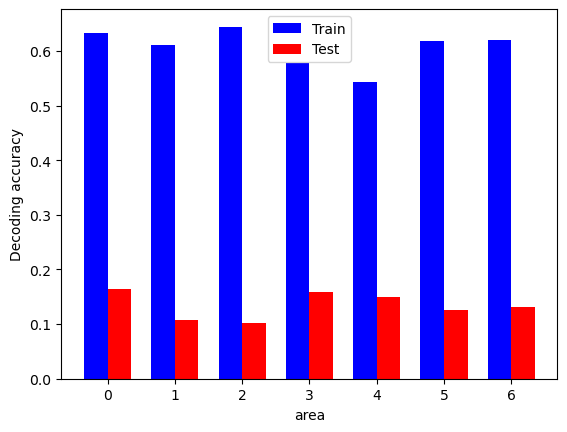

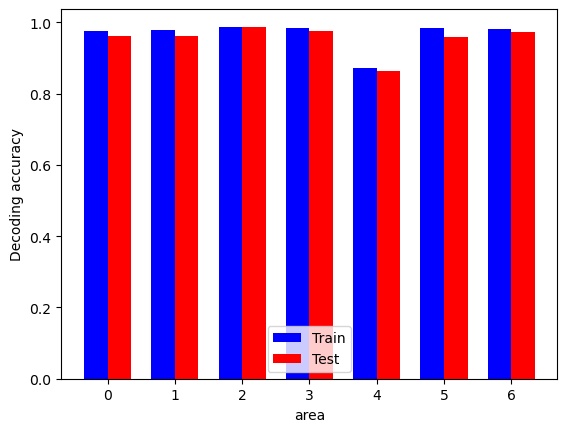

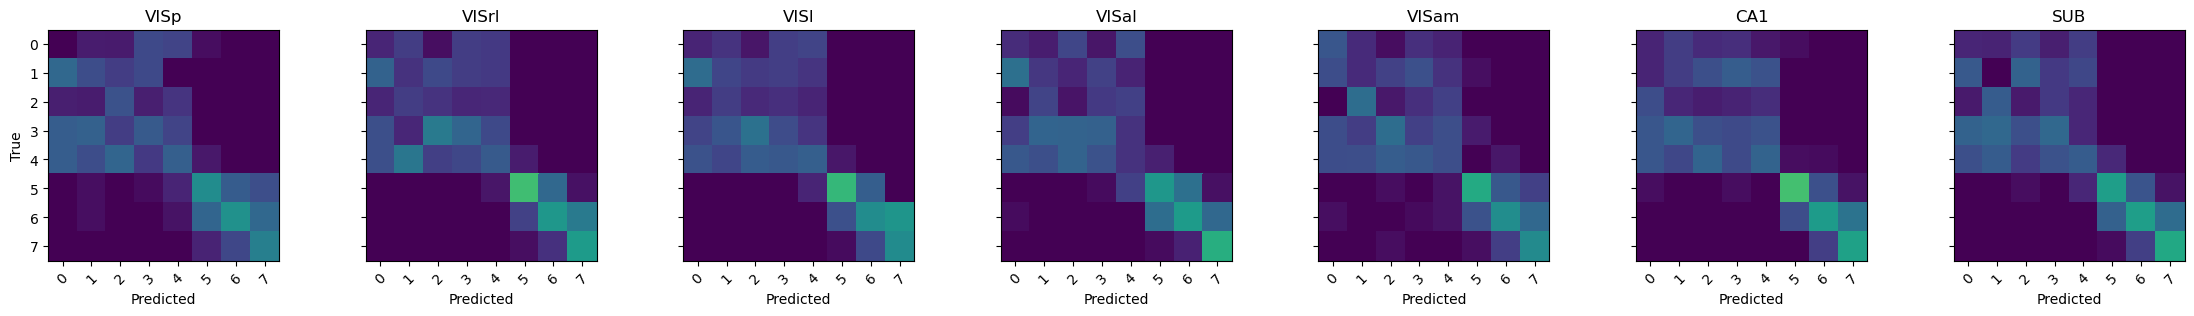

In [11]:
num_run_states = 8
n_pop = 40
train_running_labels, test_running_labels = dataset.trial_labels_for_running(num_run_states)

label_run_train = torch.tensor(train_running_labels[0], dtype=torch.long)
label_run_test = torch.tensor(test_running_labels[0], dtype=torch.long)

classifier_run_dict = dict([a, Classifier(n_pop, num_run_states)] for a in selected_areas)
classifier_is_running_dict = dict([a, Classifier(n_pop, 2)] for a in selected_areas)

confusion_mat_run_dict = {}
accuracy_run_dict = {}
accuracy_run_binary_dict = {}
for area in selected_areas:
    print(f"\n\tarea={area}")
    inds = dataset.get_neuron_indices_for_area(area)[:n_pop]

    # load data tensors
    x_train = torch.tensor(dataset.raster_list[0][train_indices]).float().mean(1)[..., inds]
    x_test = torch.tensor(dataset.raster_list[0][test_indices]).float().mean(1)[..., inds]

    C : Classifier = classifier_run_dict[area]
    C_binary : Classifier = classifier_is_running_dict[area]
    C.train()
    C_binary.train()
    optimizer = torch.optim.AdamW(list(C.parameters()) + list(C_binary.parameters()), 0.01)

    for i in range(5_000):
        C.zero_grad()
        loss = C(x_train, label_run_train)
        loss_binary = C_binary(x_train, (label_run_train >= 5).long())
        (loss + loss_binary).backward()
        optimizer.step()

        if i % 1000 == 0:
            train_acc  = C.accuracy(x_train, label_run_train)
            train_acc_binary = C_binary.accuracy(x_train, (label_run_train >= 5).int())
            test_acc = C.accuracy(x_test, label_test)
            test_acc_binary = C_binary.accuracy(x_test, (label_run_test >= 5).int())
            print(f"loss={loss.item():0.03f} train_acc={train_acc:0.2f} test_acc={test_acc:0.2f} binary={test_acc_binary:0.2f}")

    accuracy_run_dict[area] = (train_acc, test_acc)
    accuracy_run_binary_dict[area] = (train_acc_binary, test_acc_binary) #(train_acc, test_acc)
    confusion_mat_run_dict[area] = C.confusion_matrix(x_test, label_run_test)

#
accuracy_bar_plot(accuracy_run_dict)
accuracy_bar_plot(accuracy_run_binary_dict)
plot_confusion_matrices(confusion_mat_run_dict, range(num_run_states))

<b> Question: </b> Looking at the confusion matrix, how many "running state" can be reliably identified from the trial averaged running activity?


## Part 1.3 - PCA to extract the latent information encdoded the activity

variance explained: PC.1=0.186 2=0.121 3=0.095 4=0.081
variance explained: PC.1=0.144 2=0.118 3=0.105 4=0.075
variance explained: PC.1=0.264 2=0.099 3=0.056 4=0.050
variance explained: PC.1=0.152 2=0.103 3=0.079 4=0.067
variance explained: PC.1=0.175 2=0.113 3=0.094 4=0.066
variance explained: PC.1=0.303 2=0.145 3=0.080 4=0.056
variance explained: PC.1=0.500 2=0.093 3=0.054 4=0.044


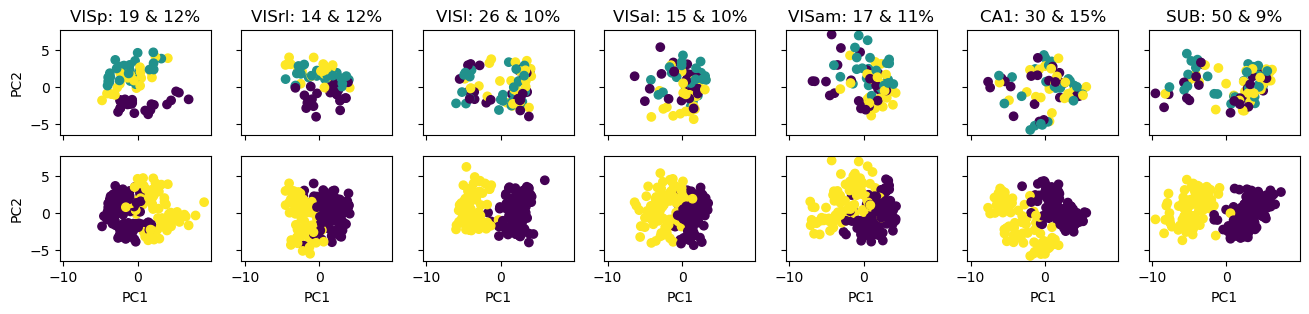

In [12]:
from numpy.linalg import svd
import numpy as np
from utils.functions import to_numpy

#
x_train_np = np.mean(dataset.raster_list[0][train_indices],1)
x_test_np = np.mean(dataset.raster_list[0][test_indices], 1)

def z_scoring(x_train, x_test=None):
    mu = x_train.mean(0)
    std = x_train.std(0)
    x_train = (x_train - mu) / np.maximum(std, 1e-8)
    if x_test is None: return x_train
    x_test = (x_test - mu) / np.maximum(std, 1e-8)
    return x_train, x_test

def pca_projection(x_train, x_test, k=2):
    x_train_normalized, x_test_normalized = z_scoring(x_train, x_test)
    B, n = x_train_normalized.shape

    ## TODO:
    # Implement standard PCA using svd from numpy.linalg or with np.cov
    # var_explained = ?? (vector of size n)
    # P_pca = ?? (PCA projection matrix of shape n x n)
    # Question: What is the relationship between SVD and covariance?
    
    # Answer (PCA theory):
    # For a mean-centred data matrix X of shape (B, n), the sample covariance is
    #   C = (1/(B-1)) * X.T @ X.
    # If we compute the SVD of X as
    #   X = U @ S_diag @ V.T,
    # then the covariance can be written as
    #   C = V @ (S_diag**2 / (B-1)) @ V.T.
    # Therefore, the columns of V are the principal components (eigenvectors of the
    # covariance matrix), and the eigenvalues of the covariance are given by S**2/(B-1).

    
    # YOUR CODE HERE
    #X has shape (B,n), already mean centered(done in z-scoring)
    U, S, Vt = svd(x_train_normalized, full_matrices=False) #Vt has shape (n,n)
    
    #eigenvalues for the covariance matrix are S**2 / (B-1)
    eigvals = (S**2) / (B-1)

    #Fraction of variance explained by each principal components
    var_explained = eigvals / eigvals.sum()

    #PCA projection matrix
    P_pca = Vt.T #shape (n,n)


    # PCA plot
    
    print(f"variance explained: PC.1={var_explained[0]:0.3f} 2={var_explained[1]:0.3f} 3={var_explained[2]:0.3f} 4={var_explained[3]:0.3f}")
    x_proj = x_test_normalized @ P_pca
    return x_proj, var_explained[:k]

fig, ax_list = plt.subplots(2, len(selected_areas), figsize=(16, 3), sharey=True, sharex=True)
for i, A in enumerate(selected_areas):
    inds = dataset.get_neuron_indices_for_area(A)[:n_pop]
    x_test_proj, var_explained = pca_projection(x_train_np[:, inds], x_test_np[:, inds], k=2)

    is_running = (to_numpy(label_run_test) >= 5)
    ax_list[0, i].set_title(f"{A}: {var_explained[0]*100:0.0f} & {var_explained[1]*100:0.0f}%")
    mask = np.isin(label_test,[2,3,4])

    ax_list[0, i].scatter(x=x_test_proj[mask,0], y=x_test_proj[mask,1], c=to_numpy(label_test)[mask])
    ax_list[1,i].scatter(x=x_test_proj[:,0], y=x_test_proj[:,1], c=is_running)
    if i == 0: ax_list[0, i].set_ylabel("PC2")
    if i == 0: ax_list[1, i].set_ylabel("PC2")
    ax_list[1, i].set_xlabel("PC1")

## Part 1.4 Single cell encoding properties

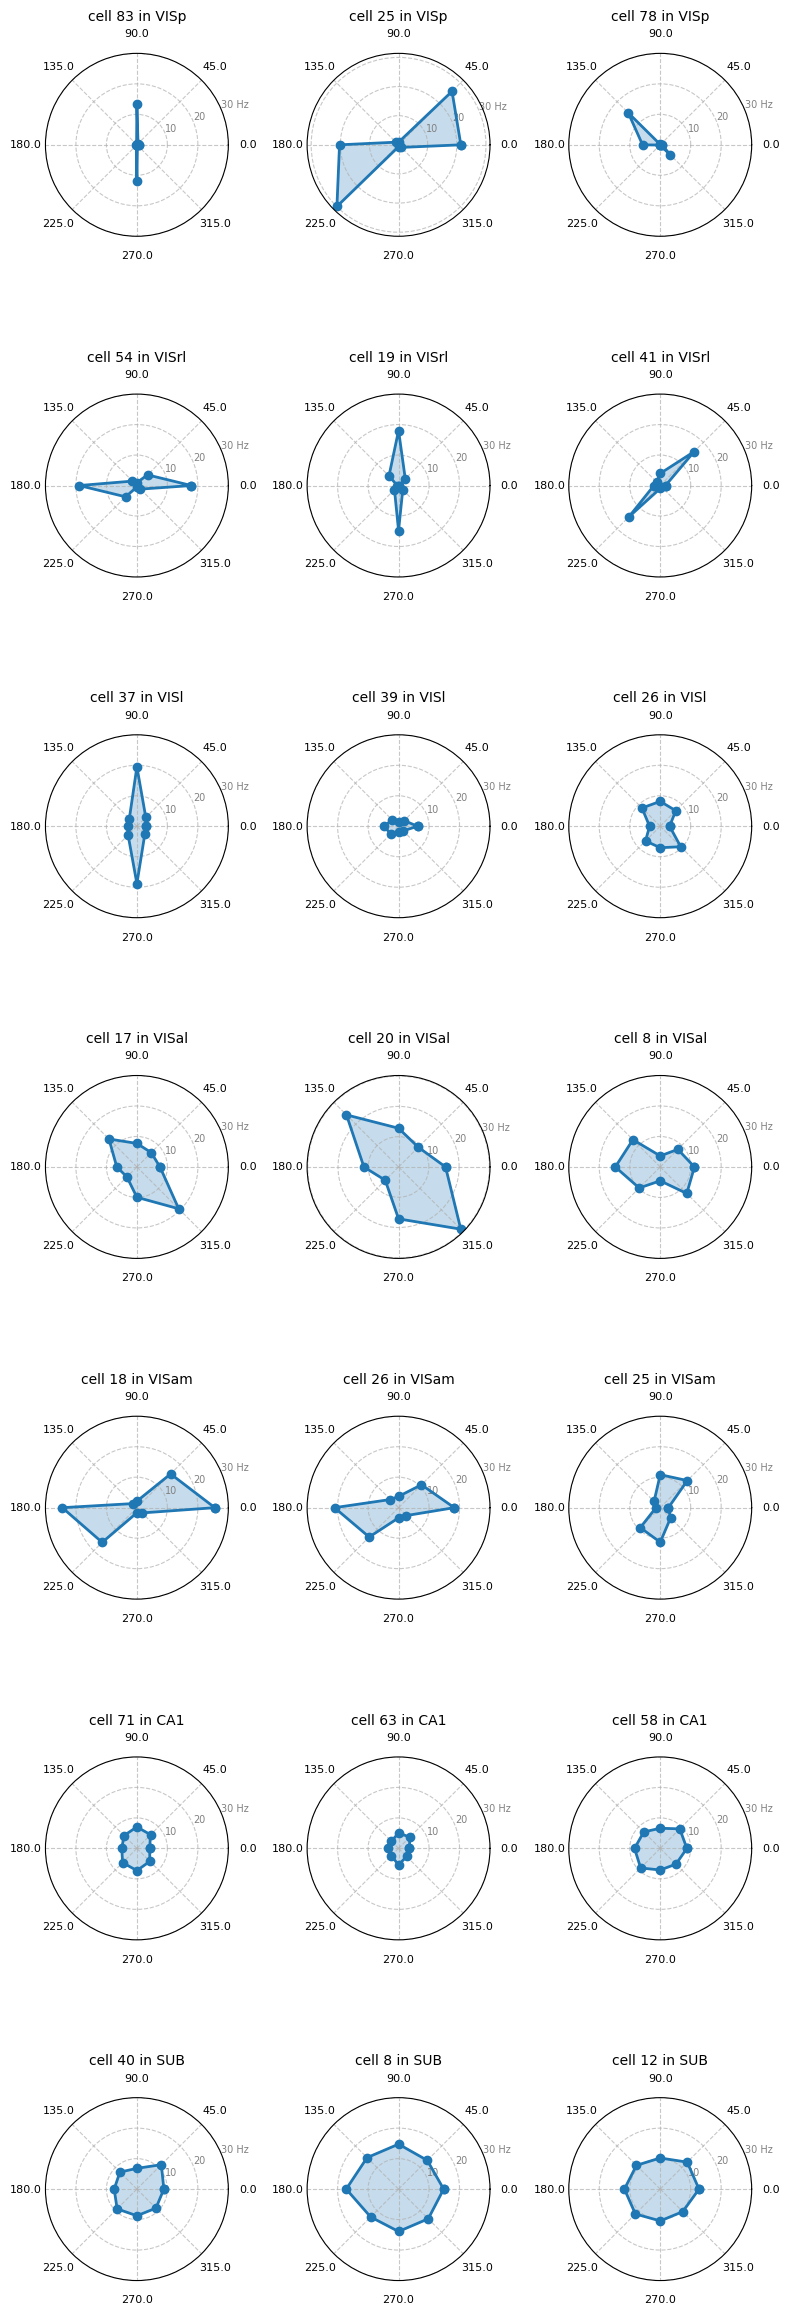

In [13]:
def selectivity_vector(x_train, label_train, num_classes):
    firings_rates = []
    for i_class in range(num_classes):
        mask = label_train == i_class
        fr = x_train[mask].mean(0) / dataset.dt
        firings_rates.append(fr)

    return np.stack(firings_rates, 0)

def radar_plot(categories, value_matrix, n_cells=3):
    # Sample data
    num_vars = len(categories)


    # Create the plot
    fig, ax_list = plt.subplots(len(selected_areas), n_cells, figsize=(8, n_cells * 8), subplot_kw=dict(projection='polar'))

    for iA, A in enumerate(selected_areas):
        for i_cell in range(n_cells):
            ax = ax_list[iA, i_cell]
            inds = dataset.get_neuron_indices_for_area(A)
            v = value_matrix[:, inds] # num_of_ori x num_of_neurons (firing rates or each neuron or each orientation in area A)
            selectivity_order = np.argsort(v.std(0) /  v.mean(0).clip(min=v.mean()) )[::-1]

            # Number of variables
            cell_fr = value_matrix[:, inds[selectivity_order[i_cell]]]


            # Compute angle for each axis
            angles = np.linspace(0, 2 * np.pi, num_vars+1, endpoint=True).tolist()
            cell_fr = list(cell_fr) + [cell_fr[0]]

            # Draw the plot
            ax.plot(angles, cell_fr, 'o-', linewidth=2, color='#1f77b4')
            ax.fill(angles, cell_fr, alpha=0.25, color='#1f77b4')

            # Set the labels
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(categories, size=8)

            # Set y-axis limits and remove labels

            ax.set_yticks([10, 20, 30])
            ax.set_yticklabels(['10', '20', '30 Hz'], size=7, color='gray')

            # Add grid
            ax.grid(True, linestyle='--', alpha=0.7)
            title = f"cell {selectivity_order[i_cell]} in {A}"
            ax.set_title(title, size=10)

    plt.tight_layout()
    plt.show()


ori_firing_rate_vector = selectivity_vector(x_train_np, label_train, len(ori_value_list))

radar_plot(ori_value_list[1:], ori_firing_rate_vector[1:])


<b> Question: </b> Looking at the single cell selectivity to stimulus orientation. What is specific to visual cortex?

In [14]:
# Answer:
# In the visual cortex (VIS areas) many neurons show strong orientation tuning:
# their firing rate is sharply peaked for one particular grating orientation and
# much lower for other orientations. This produces "spiky" radar plots with a
# clear preferred orientation for each cell. In contrast, neurons in non-visual
# areas such as CA1 and SUB do not exhibit such strong, stimulus-locked
# orientation selectivity and their tuning curves are much flatter or more
# irregular. Strong single-cell orientation tuning is therefore a characteristic
# feature of visual cortex.


In [15]:

selected_ori = ori_value_list[:4]
ori_pop_mask = np.logical_and(ori_firing_rate_vector[:4] > ori_firing_rate_vector[:4].mean() * 1.3, ori_firing_rate_vector[:4] == ori_firing_rate_vector[:4].max(0))

print("Population mask sizes")
print("selected_ori=", selected_ori)
print("ori_pop_mask sizes=", ori_pop_mask.sum(1))

Population mask sizes
selected_ori= ['null', '0.0', '45.0', '90.0']
ori_pop_mask sizes= [69 56 37 39]


## Part 2 - Generative model of the neural activity using Deep Learning



As a simple generative model of neural activity we will use a VAE.  
This approach is similar to LFADS (Pandarinath et al. 2018): https://www.nature.com/articles/s41592-018-0109-9
LFADS means Latent Factor Analysis via Dynamical Systems.

We reduce the neural activity into a 4-dim latent variable which explains (non-linearly) the neural variability.

Without supervision VAE identifies the running state (Latent dim 1 and 2 below) & stimulus condition (Latent dim 3-4 below) as major latent factors.

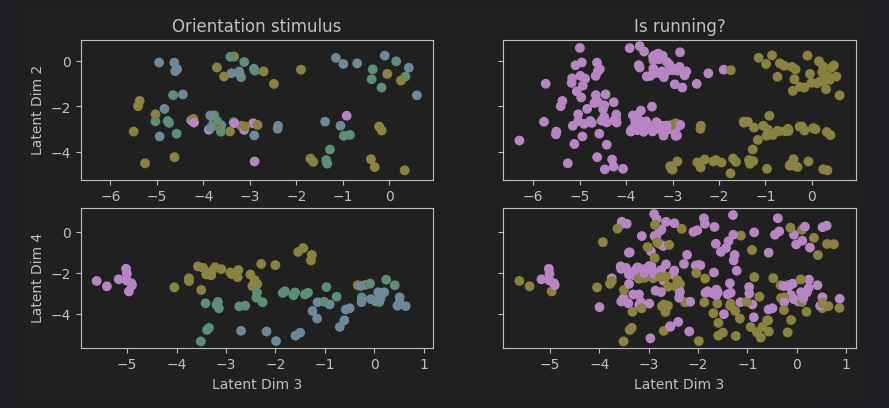



# 2.1 Success metrics for generative models

### <b>PSTH Pearson Correlation:</b> Metric for single unit trial averaged activity
We want to build metrics in [0,1] to control the quality of our generative models.
We compare two batches of spike raster $z$ with shape $(B, T, N)$ (trial number, number of time steps, number of neurons in the session).
Typically $z$ is the simulated raster plot and $z^D$ is the recorded raster plot from the data.

We implement the peristimulus time historgram (PSTH) pearson correlation.
In simple terms, PSTH means: trial average raster plot when the stimulus is timed-locked. (implemented as in https://arxiv.org/pdf/2106.10064 )
We compute the pearson correlation $\rho_i$ for each neuron's PSTH. We report the averaged $\rho_i$ (i runs over neurons) where:

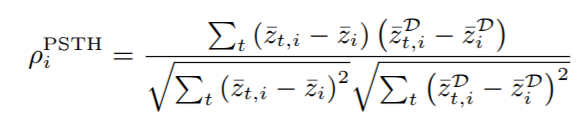


In [16]:
from utils.torch_basics import smooth

def resample(z, K):
    B = z.shape[0]
    if B < K:
        z_list = [z for _ in range(K // B)]
        if K % B != 0: z_list += z[np.random.permutation(B)[:(K % B)]]
        z = torch.cat(z_list, 0)
        assert z.shape[0] == K
        return z
    if B > K:
        return z[np.random.permutation(B)[:K]]
    assert B == K
    return z

# trial averaged loss function
def low_pass(z, tau):
    return smooth(z, tau, dataset.dt, 1, padding=False)

def pearson_corr(a, b, dim=0):
    assert a.shape[0] == b.shape[0]
    corr = ((a - a.mean(dim)) * (b - b.mean(dim))).mean(dim)/ (a.std(dim) * b.std(dim)).clamp(min=1e-6)
    return corr

def fun_psth_metrics(z1, z2, batch_size, random_sample=False):
    z1 =  resample(z1, batch_size) if random_sample else z1[:batch_size]
    z2 =  resample(z2, batch_size) if random_sample else z2[:batch_size]

    # TODO: Choose the value of tau_smoothing so that the PSTH correlation is a "reproducible" statistic.
    # 1) Make sure the PSTH corr between train and test is as high as possible.
    # 2) When shuffling time steps or neuron identity, the PSTH should be near 0 or lower.
    # tau_smoothing = ?? (float in seconds)  
    
    # YOUR CODE HERE
    tau_smoothing = 0.05  # 50 ms of temporal smoothing
    
    z1 = low_pass(z1, tau_smoothing).mean(0)
    z2 = low_pass(z2, tau_smoothing).mean(0)

    mse = (z1 - z2).pow(2).mean()
    normalizer = (z2.mean(0) - z2).pow(2).mean()
    #R2 = 1 - loss.item() / normalizer.clip(min=1e-6).item()
    corr = pearson_corr(z1, z2)

    return mse, corr.mean().item()


# plotting raster plot
def plot_raster_plots(z_simulation, z_data, k_plot_trials = 2, random_trials=True):
    B, T, N= z_simulation.shape
    if random_trials:
        # shuffle trials to select different one everytime
        perm = np.random.permutation(B)
        z_simulation = z_simulation[perm]
        z_data = z_data[perm]

    time_line = np.arange(T) * dataset.dt

    fig, ax_list = plt.subplots(k_plot_trials+1, 2, sharex=True, sharey=True, figsize=(10, 10))

    for i_trial in range(k_plot_trials+1):
        for i_z, z in zip(range(2), [z_simulation, z_data]):
            z_trial = to_numpy(z).mean(0) if i_trial == 0 else to_numpy(z)[i_trial]

            cmap = "Greys" if i_trial > 0 else "Reds"
            ax = ax_list[i_trial, i_z]
            ax.pcolor(time_line, np.arange(N), to_numpy(z_trial).T, vmin=0, vmax=1, cmap=cmap)
            if i_trial == k_plot_trials: ax.set_xlabel("Time (seconds)")
            if i_z ==0 and i_trial == 0: ax.set_ylabel("Trial averaged\nneuron #")
            elif i_z ==0: ax.set_ylabel(f"Trial {i_trial}\nneuron #")

    ax_list[0,0].set_title("Simulation")
    ax_list[0,1].set_title("Recorded spikes")
    plt.show()


batch_size = 128
z_train_tensor = torch.tensor(z_train, dtype=torch.float)
z_test_tensor = torch.tensor(z_test, dtype=torch.float)
_, T, N = z_train_tensor.shape

time_perm = np.random.permutation(T)
neuron_shuffle = np.random.permutation(N)

_, corr_psth_ref = fun_psth_metrics(z_train_tensor, z_test_tensor, batch_size)
_, corr_psth_time_shuffled = fun_psth_metrics(z_test_tensor[:, time_perm], z_test_tensor, batch_size)
_, corr_psth_neuron_shuffled = fun_psth_metrics(z_test_tensor[:, :, neuron_shuffle], z_test_tensor, batch_size)

assert corr_psth_ref > 0.35
assert corr_psth_time_shuffled < 0.1
assert corr_psth_neuron_shuffled < 0.1

print(f"PSTH correlation: \n\t Train versus Test ceiling: {corr_psth_ref:0.3f} \n\t time shuffled {corr_psth_time_shuffled:0.3f} \n\t neuron shuffled {corr_psth_neuron_shuffled:0.3f}")

PSTH correlation: 
	 Train versus Test ceiling: 0.379 
	 time shuffled -0.018 
	 neuron shuffled 0.014


### <b>Trial Matched R2 and Frechnet Distance:</b> metrics for single trial network activity.
Create PSTH is a trial-average, so does not carry any information about single. Now we deinfe metrics for <b> single trial dynamics </b>.

To reduce trial-trial variability and build reproducible statistics, we build feature vector to summarize trial activity.
We will population firing rate over the trial as stable and reliable statistics. Let's write $\mathcal{T}(z)$ as the feature vector of shape $(T,d)$ if $z$ is the raster plot of shape $(B, T, N)$.
 
The difficulty is that the trial order means nothing. So we need to find a distance between un-ordered set of vectors. We implement two methods:
- Trial matched R2 (using optimal transport via discrete optimization)
- Frechnet Distance (better known as FID in image generative models)


In [17]:
# Population averaged and trial matched loss
def pop_averaged_with_area(z):
    z_list = []
    for area in selected_areas:
        inds = dataset.get_neuron_indices_for_area(area)
        z_list.append(z[..., inds].mean(-1))
    return torch.stack(z_list, dim=-1)

def pop_averaged_with_selectivity(z):
    z_list = []
    for i_ori, ori_value in enumerate(selected_ori):
        mask = ori_pop_mask[i_ori]
        z_list.append(z[..., mask].mean(-1))
    return torch.stack(z_list, dim=-1)

def all_pop_average(z):
    return torch.cat([pop_averaged_with_selectivity(z), pop_averaged_with_area(z)], dim=-1)


def time_window_as_features(z, bin_size=50):
    # if the time projection is keeping a time dimension we keep difference time-window as different features
    B, T, n_pop = z.shape
    assert T >= bin_size
    assert T % bin_size == 0
    # average of time-bins
    z = z.reshape(B, T // bin_size, bin_size, n_pop).mean(2)
    z = z.reshape(B, T // bin_size * n_pop)
    return z


def feature_oscillation_frequency(X, f_min=2, f_max=30, num_f=24 * 4, n_group=3):
    B, T, d = X.shape
    X = to_numpy(X)

    X_mean = X.mean(1) # dim: B x d 
    X = X - X_mean[:, None, :]
    dt = 0.01

    coeff = (f_max/f_min)**(1/(num_f - 1))
    #freqs = torch.linspace(f_min, f_max, num_f, device=X.device)
    freqs = f_min * np.power(coeff, np.arange(num_f))
    assert freqs[0] == f_min
    assert (freqs[-1] - f_max) / f_max < 1e-4, f"f_max={freqs[-1]} and not f_max={f_max}"
    time_line = np.arange(T) * dt
    cos = np.cos(np.pi * freqs[None,:] * time_line[:, None]) # dim: T x F
    sin = np.sin(np.pi * freqs[None,:] * time_line[:, None]) # dum: T X F
    Z_cos = (X[..., None] * cos[:,None,:]).mean(1)
    Z_sin = (X[..., None] * sin[:,None,:]).mean(1)
    Z = np.sqrt(Z_cos**2 + Z_sin**2) # dim: B x d x F
    if n_group is None: n_group = num_f
    Z = Z.reshape(B, d, n_group, num_f // n_group).mean(-1)
    Z_cst = X_mean[..., None]
    Z = np.concatenate([Z,Z_cst], -1).reshape(B, -1)
    assert Z.shape[-1] == d * (n_group+1), f"wrong number of dim"
    return Z.reshape(B,-1)


We implement <b>trial matched R2</b> to address 1,2 and 4. The idea is to compare distributions of raster plots when the data order is not known.
We use a feature vector $ \mathcal{T'}_{trial} (z) $ which is a non-linear projection of the raster plot $z$ with shape $(B, d)$.

Then we find the optimal pair-wise assignent $\pi$ between the generated and test feature vectors.
Since we take the optimal order this is trial-order invariant  such that:

$$ R^2_{trial-matched} = 1 - \frac{\min_{\pi} \sum_k || T(z^D)_k - T(z)_{\pi(k)} ||^2}{ \sum_k || T(z^D)_k - T(z^D)_{mean} ||^2} $$


Alternatively, one can use the Frechnet Distance (FD, often called FID in image generative modeling).
Considering the statistics on the simulated data
$\mu_{simu}=\operatorname{mean}(\mathcal{T}(z))$ and $\Sigma_{simu}=\operatorname{cov}(\mathcal{T}(z))$,
and the same statisitcs on the recorded data we compute the Frechnet distance between two Gaussians.


$$ FD = ||mu_{simu} - mu_D||^2 + Tr(\Sigma_{simu} + \Sigma_D - 2 (\Sigma_{simu} \Sigma_D)^{0.5}) $$

In [18]:
from scipy.optimize import linear_sum_assignment
from utils.torch_basics import MyBatchNorm1d, calculate_frechet_distance

def trial_matched_R2(X_simu, X_data, already_matched=False):
    """
    Take torch tensors of simulated and recorded features with shape (B, d).

    returns:
    mse: The corresponding trial-matched mean square error loss (non-negative floating point number) such that mse = C[ind_simu, ind_data]
    R2: The trial-matched R2 (floating point number lower than 1 and 0)
    ind_simu: array of integers to select the simulation trial order for the optimal match.
    ind_data: array of integers to select the data trial order for the optimal match.
    """
    B = X_simu.shape[0]
    if not X_simu.shape[0] == X_data.shape[0]:
        raise NotImplementedError("default implementation with linear_sum_assignment only makes since with equal batch sizes.")

    if already_matched:
        # simple case, where the order of trial is already matching
        # This is the case if the latent is encoded with the VAE encoder, but not if we sample randomly in the latent
        ind_simu, ind_data = np.arange(B), np.arange(B)
        mse = np.power(X_simu - X_data,2).mean()
    else:
        # TODO:
        # Implement the trial matching loss function using the scipy function: linear_sum_assignment(to_numpy(...))
        # ind_simu, ind_data = ??
        # mse = ??
        
        # YOUR CODE HERE
        C = ((X_simu[:, None, :] - X_data[None, :, :]) ** 2).mean(-1)  # shape (B, B)
        row_ind, col_ind = linear_sum_assignment(to_numpy(C))

        ind_simu = row_ind
        ind_data = col_ind
        mse = C[ind_simu, ind_data].mean()

    normalizer = np.power(X_data.mean() - X_data, 2).mean()
    R2 = 1 - mse.item() / normalizer.clip(min=1e-6).item()
    
    return mse, R2, ind_simu, ind_data

def fun_trial_matched_metrics(z_simulated, z_data, batch_size, feature_fun, random_sample=False, already_matched=False):
    z_simulated =  resample(z_simulated, batch_size) if random_sample else z_simulated[:batch_size]
    z_data =  resample(z_data, batch_size) if random_sample else z_data[:batch_size]

    # Could be population average activity or non-linear feature extraction?
    X_simu = feature_fun(z_simulated)
    X_data = feature_fun(z_data)

    assert len(X_simu) == len(X_data)
    assert len(X_simu.shape) == 2

    # now the features have shape: (B, d) where d in the feature vector size
    mse, R2, indx, indy = trial_matched_R2(X_simu, X_data, already_matched=already_matched)

    if random_sample:
        return R2
    return R2, indx, indy

def frechenet_distance(z_simulated, z_data, batch_size, feature_fun, random_sample=False):
    z_simulated =  resample(z_simulated, batch_size) if random_sample else z_simulated[:batch_size]
    z_data =  resample(z_data, batch_size) if random_sample else z_data[:batch_size]

    # Could be population average activity or non-linear feature extraction?
    z1 = to_numpy(feature_fun(z_simulated))
    z2 = to_numpy(feature_fun(z_data))

    mu1 = np.mean(z1, axis=0)
    mu2 = np.mean(z2, axis=0)
    sigma1 = np.cov(z1, rowvar=False)
    sigma2 = np.cov(z2, rowvar=False)

    return calculate_frechet_distance(mu1, sigma1, mu2, sigma2)

z_test_time_shuffled = z_test_tensor[:,np.random.permutation(T)]
z_test_neuron_shuffled = z_test_tensor[:,:,np.random.permutation(N)]


#feature_fun = lambda z : time_window_as_features(pop_averaged_with_area(z), bin_size=50)
feature_fun = lambda z : feature_oscillation_frequency(all_pop_average(z))
#feature_fun = lambda z : time_window_as_features(pop_averaged_with_selectivity(z))

X_train = feature_fun(z_train_tensor)

def normalized_feature_fun(z):
    features = feature_fun(z)
    #features = (features - X.mean()) / X.std()
    return (features - X_train.mean(0)) / (X_train.std(0) + 1e-6)

normalized_feature_fun(z_train_tensor).shape

ff = normalized_feature_fun

# R2 trial matched
R2_ref, indx, indy = fun_trial_matched_metrics(z_train_tensor, z_test_tensor, batch_size, ff)
R2_time_shuffled, *_ = fun_trial_matched_metrics(z_test_time_shuffled, z_test_tensor, batch_size, ff)
R2_neuron_shuffled, *_ = fun_trial_matched_metrics(z_test_neuron_shuffled, z_test_tensor, batch_size, ff)
R2_with_trial_matching, *_ = fun_trial_matched_metrics(z_train_tensor, z_test_tensor, batch_size, ff, already_matched=True)

# FD distance
FD_ref = frechenet_distance(z_train_tensor, z_test_tensor, batch_size, ff)
FD_time_shuffled = frechenet_distance(z_test_time_shuffled, z_test_tensor, batch_size, ff)
FD_neuron_shuffled = frechenet_distance(z_test_neuron_shuffled, z_test_tensor, batch_size, ff)

print("Reference R2: ")
print(f"\t FD ref={FD_ref:0.3f} time shuffled={FD_time_shuffled:0.3f} neuron shuffled={FD_neuron_shuffled:0.3f}")
print(f"\t Trial matched R2 ref={R2_ref:0.3f} time shuffled={R2_time_shuffled:0.3f} neuron shuffled={R2_neuron_shuffled:0.3f} without matching={R2_with_trial_matching:0.3f}")

# Verify that the Trial matched R2 makes a good comparison
assert R2_ref > 0.25, f"The R2 comparison train and test distribution should yield a high similarity. R2_ref={R2_ref:0.3f}"
assert R2_time_shuffled < 0.1, f"Shuffling time index should break the R2. {R2_time_shuffled:0.3f}"
assert R2_neuron_shuffled < 0.1, f"Shuffling neuron index should break the R2. {R2_neuron_shuffled:0.3f}"
assert R2_with_trial_matching < 0.1, f"Not doing the trial matching operation should break the R2. {R2_with_trial_matching:0.3f}"

Reference R2: 
	 FD ref=7.136 time shuffled=29.411 neuron shuffled=115.148
	 Trial matched R2 ref=0.349 time shuffled=0.025 neuron shuffled=-1.771 without matching=-0.900


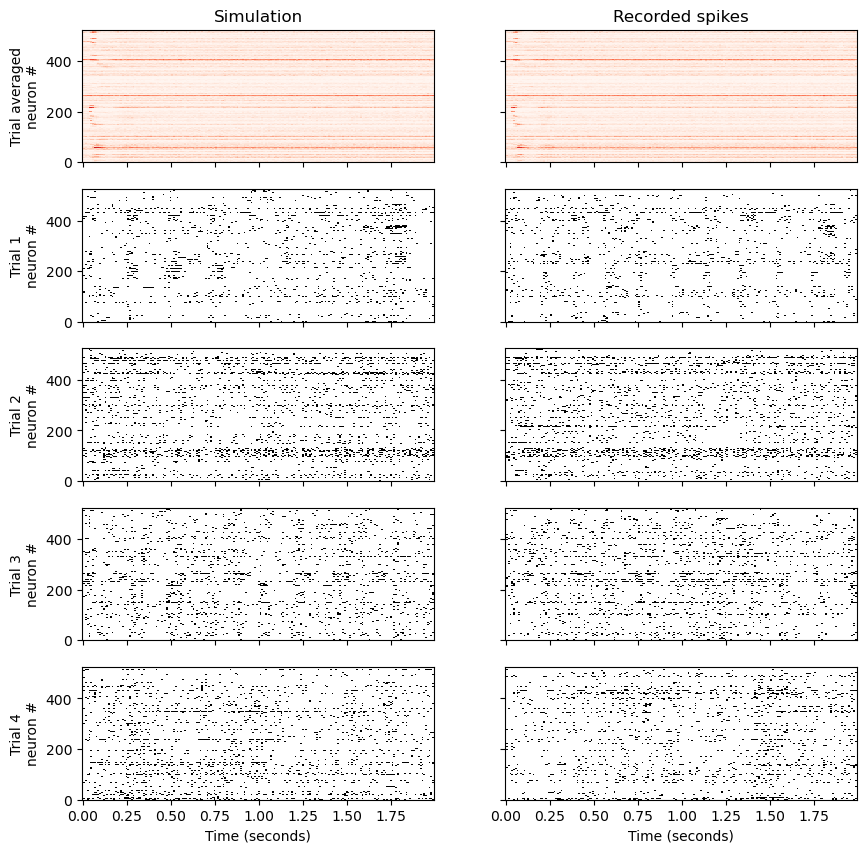

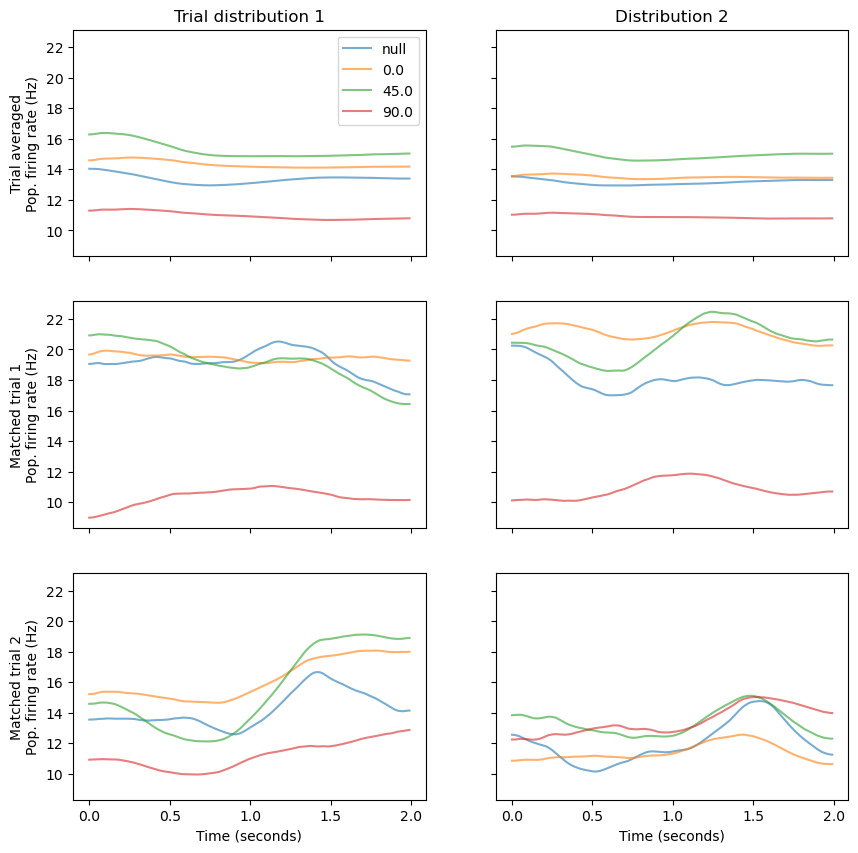

In [19]:
def plot_population_average_plots(z_simulation, z_data, k_plot_trials = 2):
    B, T, N= z_simulation.shape
    time_line = np.arange(T) * dataset.dt

    z_sim_pop = low_pass(pop_averaged_with_selectivity(z_simulation), 0.5)
    z_data_pop = low_pass(pop_averaged_with_selectivity(z_data), 0.5)

    fig, ax_list = plt.subplots(k_plot_trials+1, 2, sharex=True, sharey=True, figsize=(10, 10))

    for i_trial in range(k_plot_trials+1):
        for i_z, z_pop in zip(range(2), [z_sim_pop, z_data_pop]):
            z_trial_pop = to_numpy(z_pop).mean(0) if i_trial == 0 else to_numpy(z_pop)[i_trial]

            ax = ax_list[i_trial, i_z]
            for iA, A in enumerate(selected_ori):
                ax.plot(time_line, z_trial_pop[:, iA] / dataset.dt, alpha=0.6, label=A)

            
            if i_z == 0 and i_trial == 0: ax.legend()
            if i_trial == k_plot_trials: ax.set_xlabel("Time (seconds)")
            if i_z ==0 and i_trial == 0: ax.set_ylabel("Trial averaged\nPop. firing rate (Hz)")
            elif i_z ==0: ax.set_ylabel(f"Matched trial {i_trial}\nPop. firing rate (Hz)")

    ax_list[0,0].set_title("Trial distribution 1")
    ax_list[0,1].set_title("Distribution 2")
    plt.show()

def plot_latent(latent, label_ori, label_run):
    latent = to_numpy(latent)
    label_ori = to_numpy(label_ori)
    label_run = to_numpy(label_run)

    n_dim = latent.shape[1]

    dp = 3
    fig, ax_list = plt.subplots(n_dim // 2, 2, figsize=(2 * dp, n_dim // 2 * dp), sharey="row", sharex="row")
    if n_dim <= 2: ax_list = np.stack([ax_list])
    mask = np.isin(label_ori, [0,1,2,3])

    is_running = label_run >= 5

    ax_list[0, 0].set_title("Orientation stimulus")
    ax_list[0, 1].set_title("Is running?")

    for i in range(n_dim // 2):
        ax_list[i, 0].scatter(x=latent[mask, 2*i],y=latent[mask, 2*i+1], c=label_ori[mask])
        ax_list[i, 1].scatter(x=latent[:, 2*i],y=latent[:, 2*i+1], c=is_running)
        ax_list[i,0].set_xlabel(f"Latent Dim {2*i+1}")
        ax_list[i,1].set_xlabel(f"Latent Dim {2*i+1}")
        ax_list[i,0].set_ylabel(f"Latent Dim {2*i+2}")
        #ax_list[i,1].set_ylabel(f"Latent Dim {2*i+2}")

    plt.show()

_, ind_simu, ind_data = fun_trial_matched_metrics(z_train_tensor, z_test_tensor, batch_size, ff)
plot_raster_plots(z_train_tensor[ind_simu], z_test_tensor[ind_data], k_plot_trials = 4)
plot_population_average_plots(z_train_tensor[ind_simu],z_test_tensor[ind_data])

## 2.2 Variational Auto Encoder (VAE) for spiking activity

Recall on variational auto encoder:
[VAE on wikipedia](https://en.wikipedia.org/wiki/Variational_autoencoder)  
[Introduction to VAE by the Kingma and Welling (original authors)](https://arxiv.org/abs/1906.02691)  
[LFADS paper from 2018: first application of VAE to neural activity](https://www.nature.com/articles/s41592-018-0109-9)  

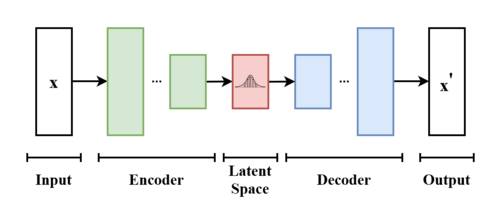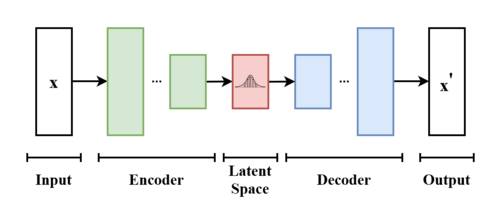

### Our VAE implementation in the notebook: 
### Encoder: Spikes2Vec
```
Input Spikes (B × T × N)
    ↓
ResLSTM 
    ↓
Mean over time
    ↓
Encoded (B × d_net)
```

### Latent Space (classical VAE reparametrization trick)
```
Encoded (B × d_net)
    ├─→ MLP → μ (B × d_latent)
    └─→ MLP → log σ² (B × d_latent)
         ↓
    Reparametrize: z = μ + σ·ε
         ↓
    Latent z (B × d_latent)
```

### Decoder: Vec2Spikes
```
Inputs: Latent z (B × d_latent) and Positional Encoding (T × d_time)
    ↓
Combine them to shape (B x T x d)
    ↓
ResLSTM
    ↓
Linear(d → N)
    ↓
Logits (B × T × N)
```

### Loss
- **Reconstruction**: Binary cross-entropy on spike probabilities
- **KL Divergence**: DKL(q(z|x) || N(0,I))



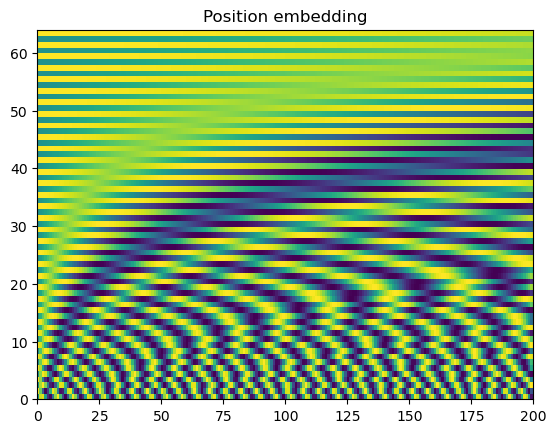

In [20]:
from utils.torch_basics import PositionalEncoding
from utils.functions import to_numpy
from utils.torch_basics import PositionalEncoding, MyScaler, smooth, MyBatchNorm1d, causal_conv1d
from numpy.linalg import eigvals

# We use the same positional encoding as in the classical Transformer paper.
pe = PositionalEncoding(64, 200)
M = pe(0,200)

plt.title("Position embedding")
plt.pcolor(M.T)
plt.show()


In [21]:
class ResLSTM(nn.Module):
    """
    Generic LSTM-based sequence-to-sequence model
    """

    def __init__(self, d):
        super().__init__()
        d_net = d
        self.lstm1 = nn.LSTM(input_size=d_net, hidden_size=d_net//2, num_layers=2, dropout=0.1, bidirectional=True, batch_first=True)
        self.bn1 = MyBatchNorm1d(d_net)
        self.lstm2 = nn.LSTM(input_size=d_net, hidden_size=d_net//2, num_layers=2, dropout=0.1, bidirectional=True, batch_first=True)
        self.bn2 = MyBatchNorm1d(d_net)

    def forward(self, x): # dim: (B, T, d)
        x = self.bn1(x + self.lstm1(x)[0])
        x = self.bn2(x + self.lstm2(x)[0])
        return x # dim: (B, T, d)


# Short-cut function to make an MLP
def make_mlp(d_in, d_hidden, d_out):
    return nn.Sequential(nn.Linear(d_in,d_hidden), nn.ReLU(), nn.Linear(d_hidden, d_out))

class Spikes2Vec(nn.Module):
    """
    Simple deep learning model to transform a raster of shape (B, T, N) into a low dimensional latent of shape (B, d)
    """

    def __init__(self, N, d_net):
        super().__init__()
        self.proj_input = nn.Linear(N,d_net)
        self.input_norm = MyBatchNorm1d(N)
        self.lstm = ResLSTM(d_net)
        self.bn = MyBatchNorm1d(d_net)

    def forward(self, z):
        z = self.proj_input(self.input_norm(z)) # dim: (B x T x d_net)

        # TODO:
        # Using the modules defined in init. Implement the Encoder:
        # Should be ~2 lines.
        
        # YOUR CODE HERE
        # Answer:
        # First we pass the projected spikes through the residual LSTM to extract
        # temporal features for each time bin (B x T x d_net). Then we perform
        # mean pooling over time to obtain a single feature vector per trial
        # (B x d_net).
        out = self.lstm(z)          # (B, T, d_net)
        out = out.mean(1)           # (B, d_net)

        out = self.bn(out) # out: (B x d_net)
        return out

class Vec2Spikes(nn.Module):
    """
    Simple deep learning model to transform a low-dimensional latent of shape (B, d) into a firing probability or shape (B, T, N)
    """

    def __init__(self, d_latent, N, d=32, d_time=64):
        super().__init__()
        self.d = d
        self.N = N
        self.pe = PositionalEncoding(d_time, T=dataset.n_t)

        # Encode the latent variable
        self.proj_latent = nn.Linear(d_latent, d)
        self.proj_time = nn.Linear(d_time, d)

        self.lstm_encoder = ResLSTM(d)
        self.proj_encoder = nn.Linear(d,N)

        self.bn_latent = MyBatchNorm1d(d)
        self.bn_time = MyBatchNorm1d(d)

    def forward(self, latent, t0, tend):
        B, d_latent = latent.shape
        # Encode latent to d-dim and normalise
        latent = self.bn_latent(self.proj_latent(latent))  # dim: B x d

        time_latent = self.pe(t0, tend).to(latent.device)
        time_latent = self.bn_time(self.proj_time(time_latent)) # dim: T x d

        assert list(latent.shape) == [B, self.d]
        assert list(time_latent.shape) == [tend-t0, self.d]

        # TODO:
        # Using the modules defined in init. Finish the implementation of the decoder as described in the markdown above.
        # Should be ~3 lines

        # YOUR CODE HERE
        # Answer:
        # We broadcast the latent vector over time and add the time-dependent
        # positional embedding to obtain a sequence of d-dimensional inputs
        # (B x T x d). This sequence is processed by the residual LSTM and then
        # projected linearly to N output units to obtain spike logits.
        T = tend - t0
        h = latent[:, None, :] + time_latent[None, :, :]  # (B, T, d)
        h = self.lstm_encoder(h)                          # (B, T, d)
        u_latent = self.proj_encoder(h)                   # (B, T, N)
        
        return u_latent # dim: B x T x N

class VAE(nn.Module):
    """
    This is a spike recording VAE similar to LFADS
    https://arxiv.org/abs/1608.06315
    https://www.nature.com/articles/s41592-018-0109-9
    """

    def __init__(self, d_net=64, d_latent=2):
        super().__init__()
        self.d_net = d_net
        self.encoder = Spikes2Vec(N, d_net)
        self.decoder = Vec2Spikes(d_latent, N, d_net)

        self.latent_mean = make_mlp(d_net, d_net, d_latent)
        self.latent_var = make_mlp(d_net, d_net, d_latent)

    def encode(self, z):
        x = self.encoder(z)
        mu = self.latent_mean(x)
        logvar = self.latent_var(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        return mu + std * torch.randn_like(std)

    def decode(self, latent, t0=0, tend=T):
        return self.decoder(latent,t0,tend)

    def forward(self, z_target, t0, tend):
        B, T, _ = z_target.shape
        mu, logvar = self.encode(z_target) # dim: B x d_latent (both)
        latent = self.reparametrize(mu, logvar) if self.training else mu # dim: B x d_latent

        loss_dkl = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp()) # VAE Prior: latent should be gaussian of mean 0 and Covariance I
        loss_dkl = loss_dkl.mean() #.clip(min=0.5).sum(-1).mean() # beta VAE clip trick to stabilize training
        u_decoded = self.decoder(latent,t0,tend)
        # Binary spikes are, for instance, a Bernoulli with probability sigmoid(u)
        return u_decoded, latent, loss_dkl


def spike_loss(logits, z_target, balanced=False):
    B, T, _ = z_target.shape
    s = z_target.sum()

    if balanced:
        mask = torch.logical_or(z_target > 0.5, torch.rand_like(z_target) < s / T)
        logits, z_target = logits[mask], z_target[mask]

    #return torch.relu(- (2*z_target-1) * logits).sum() #/ T / B
    return F.binary_cross_entropy_with_logits(logits, z_target)

# set some random sizes:
z_train = dataset.raster_list[0][train_indices]
z_test = dataset.raster_list[0][test_indices]

B, T, N = z_train.shape
n_cond = len(ori_value_list)
print(f"z_train={z_train.shape}")

# build RNN and run it:
d_net, d_latent = 32, 2
z_demo = torch.tensor(z_train[:10], dtype=torch.float)

vae = VAE(d_net=d_net, d_latent=d_latent)
u, latent, loss_dkl = vae(z_demo, 0, T)
u.shape, latent.shape

z_train=(416, 200, 525)


(torch.Size([10, 200, 525]), torch.Size([10, 2]))

device=cuda:0
epoch=0 cell time=3s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 52.1 / 18.7 / 18.5 	 54.8 / 1.7 / 1.7 	 51.5 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=0.057/0.002 MLE=0.733/0.704
	 Metrics: train/test/gen:  
		 PSTH corr=0.010/0.007/-0.004 (ref=0.379)	 R2=-148.65/-137.83/-137.63 (ref=0.35) 	 FD=6489.00/6598.59/6587.68 (ref=7.14)


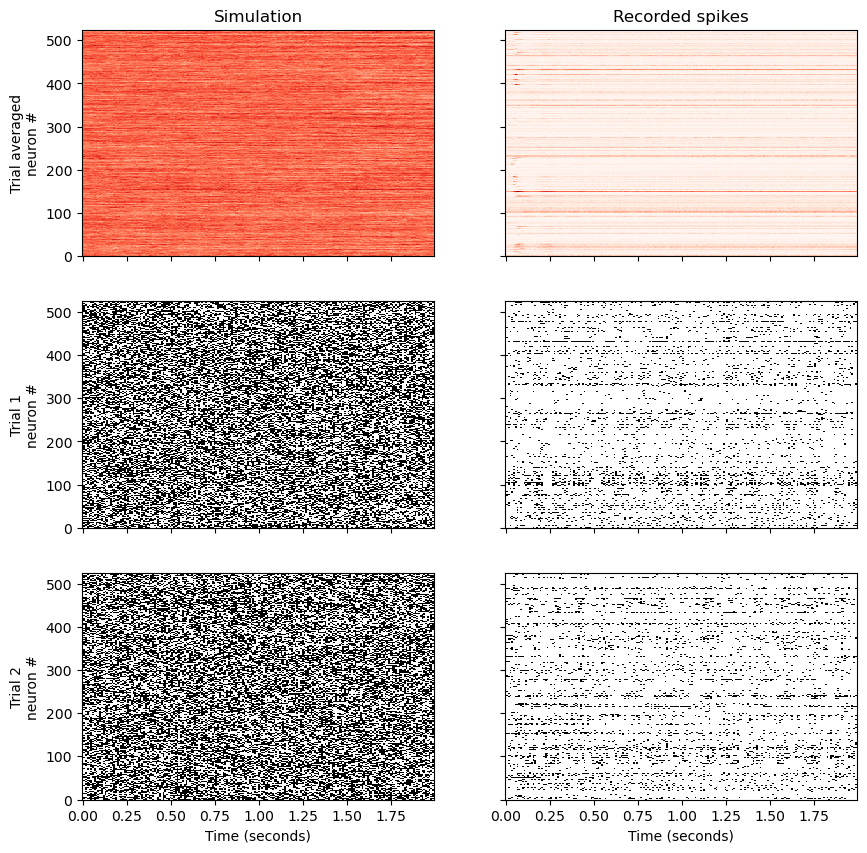

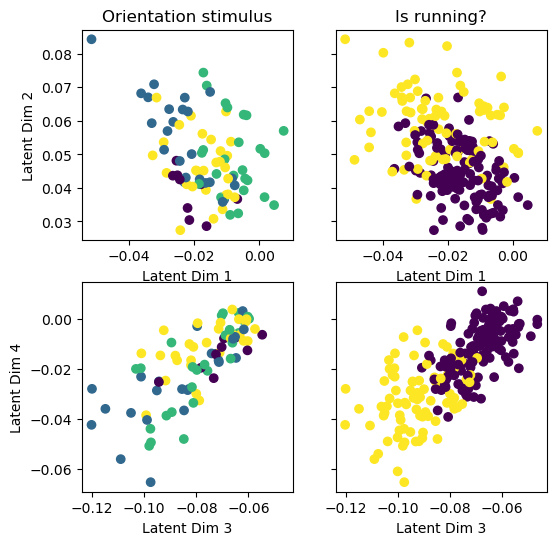

epoch=50 cell time=16s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 20.1 / 18.7 / 18.5 	 5.9 / 1.7 / 1.7 	 19.6 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=0.252/0.251 MLE=0.225/0.225
	 Metrics: train/test/gen:  
		 PSTH corr=0.169/0.148/0.150 (ref=0.379)	 R2=-1.48/-1.46/-1.41 (ref=0.35) 	 FD=94.18/101.81/100.32 (ref=7.14)
epoch=100 cell time=22s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 18.7 / 18.7 / 18.5 	 2.0 / 1.7 / 1.7 	 21.0 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=0.432/0.436 MLE=0.209/0.208
	 Metrics: train/test/gen:  
		 PSTH corr=0.278/0.239/0.221 (ref=0.379)	 R2=-1.00/-0.89/-0.88 (ref=0.35) 	 FD=74.54/76.64/75.45 (ref=7.14)
epoch=150 cell time=29s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 18.7 / 18.7 / 18.5 	 1.7 / 1.7 / 1.7 	 21.0 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=0.496/0.477 MLE=0.208/0.206
	 Metrics: train/test/gen:  
		 PSTH corr=0.359/0.286/0.282 (ref=0.379)	 R2=-0.98/-0.81/-0.79 (ref=0.35) 	 FD=73.40/73.12/70.72 (ref=

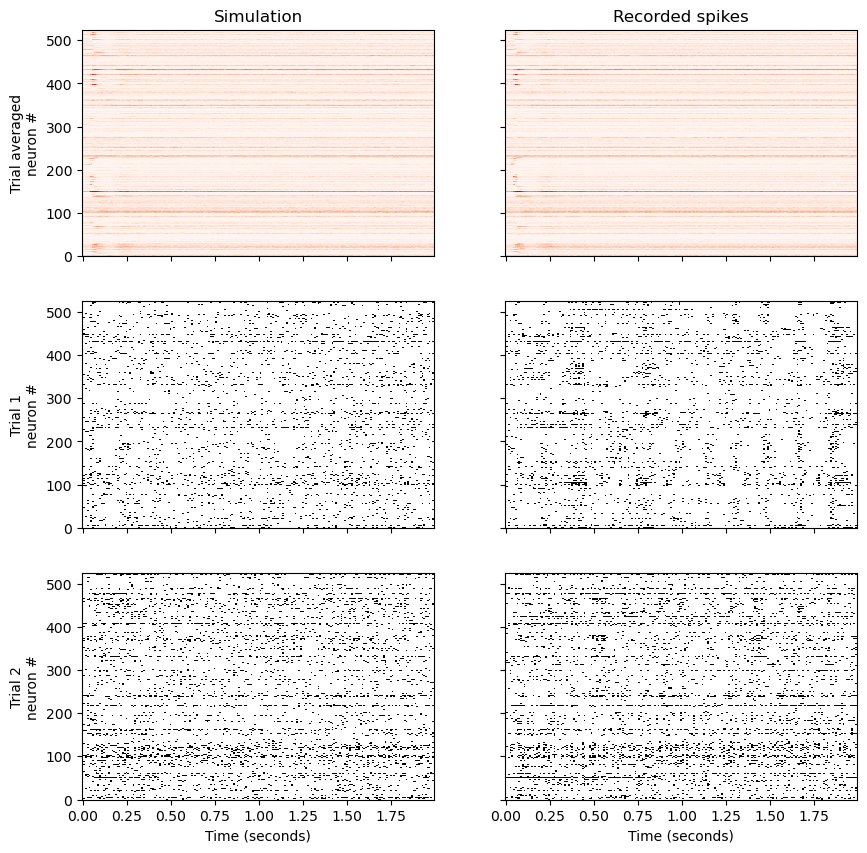

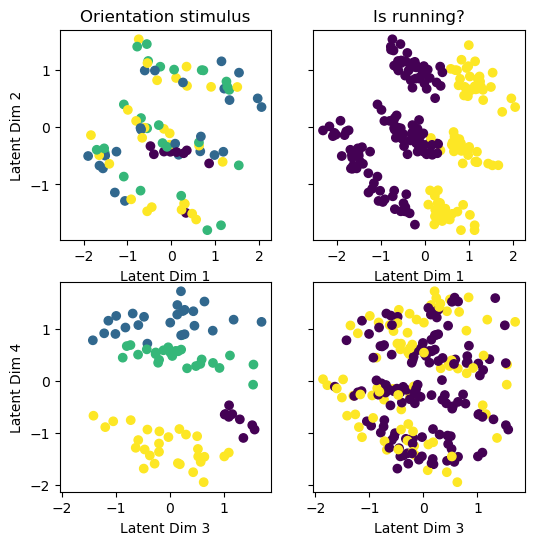

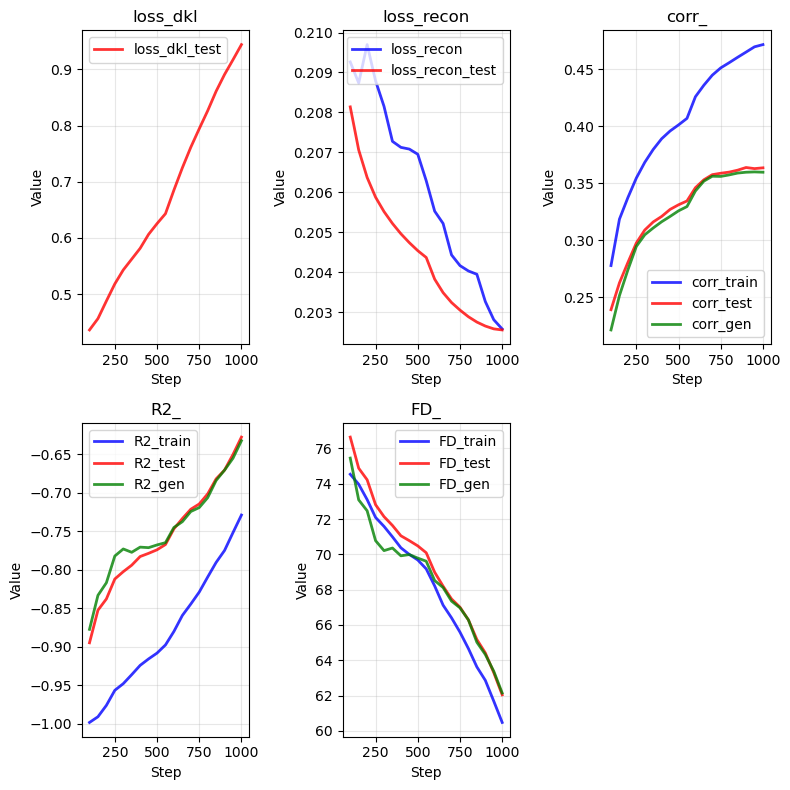

epoch=1050 cell time=158s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 19.0 / 18.7 / 18.5 	 1.7 / 1.7 / 1.7 	 21.2 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=1.138/1.097 MLE=0.201/0.203
	 Metrics: train/test/gen:  
		 PSTH corr=0.492/0.363/0.361 (ref=0.379)	 R2=-0.60/-0.48/-0.52 (ref=0.35) 	 FD=54.17/54.24/56.32 (ref=7.14)
epoch=1100 cell time=165s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 19.0 / 18.7 / 18.5 	 1.7 / 1.7 / 1.7 	 21.1 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=1.164/1.128 MLE=0.198/0.203
	 Metrics: train/test/gen:  
		 PSTH corr=0.493/0.361/0.357 (ref=0.379)	 R2=-0.52/-0.40/-0.47 (ref=0.35) 	 FD=49.78/49.49/53.67 (ref=7.14)
epoch=1150 cell time=172s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 18.5 / 18.7 / 18.5 	 1.7 / 1.7 / 1.7 	 20.7 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=1.194/1.140 MLE=0.205/0.203
	 Metrics: train/test/gen:  
		 PSTH corr=0.507/0.356/0.362 (ref=0.379)	 R2=-0.54/-0.41/-0.37 (ref=0.35) 	 FD=51.62/51.00/48.06 

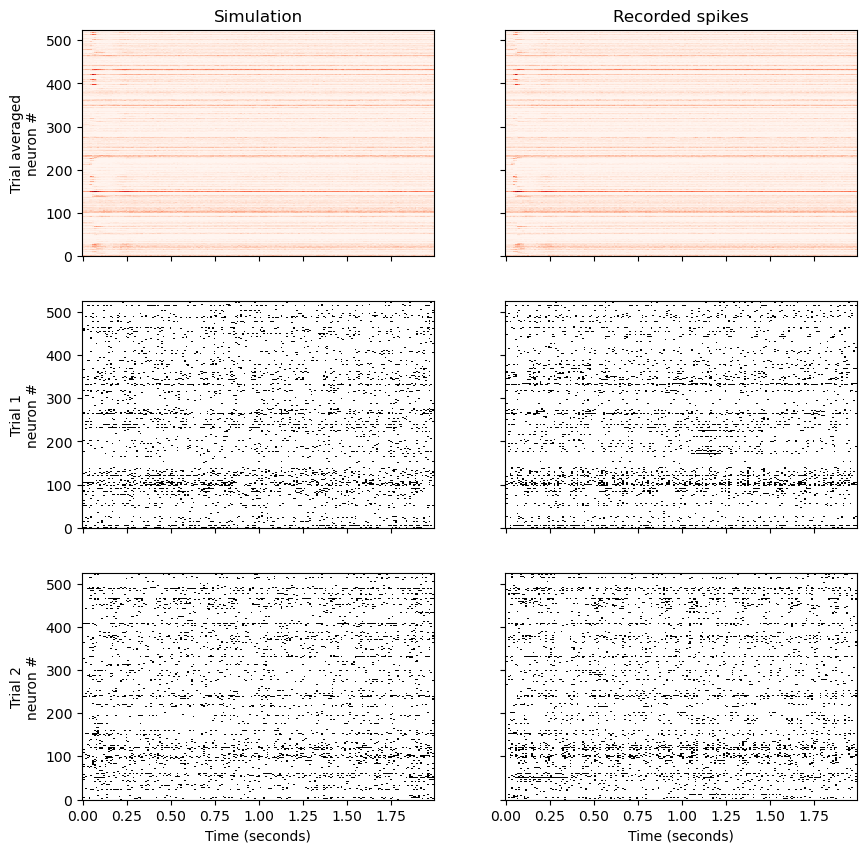

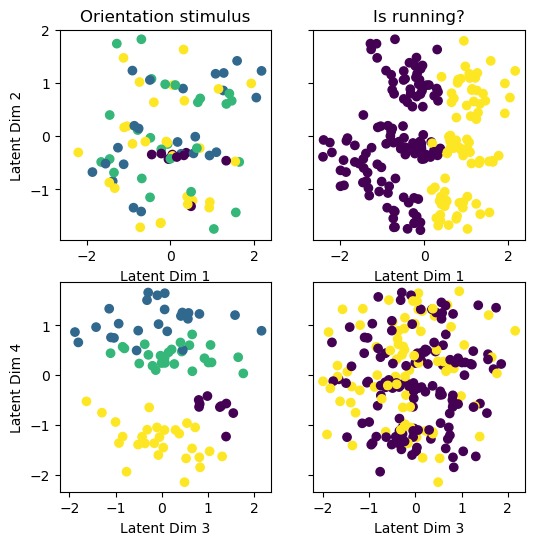

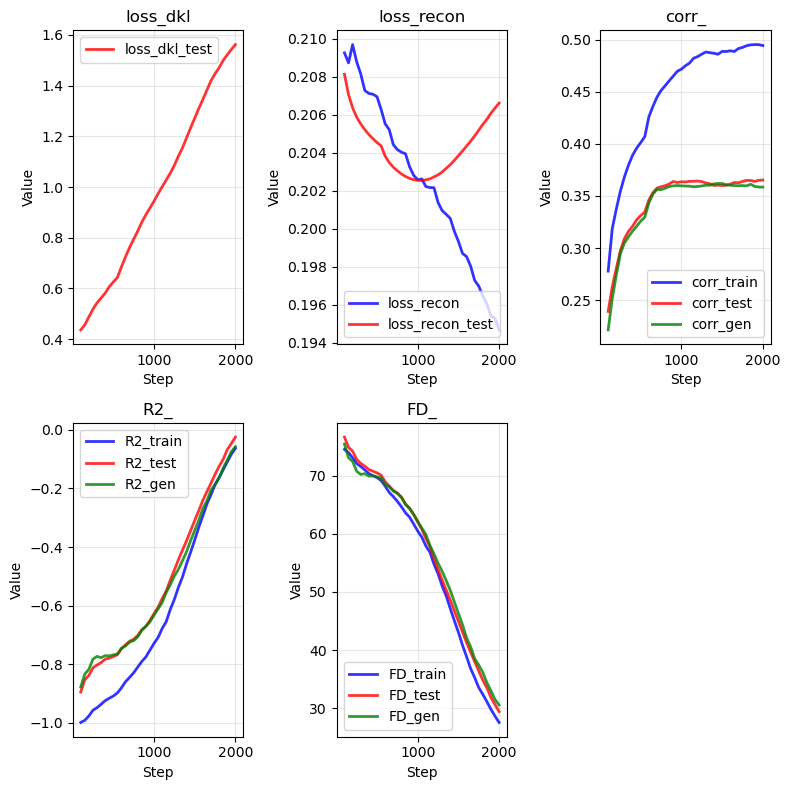

epoch=2050 cell time=301s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 18.0 / 18.7 / 18.5 	 1.5 / 1.7 / 1.7 	 21.1 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=1.726/1.657 MLE=0.197/0.208
	 Metrics: train/test/gen:  
		 PSTH corr=0.503/0.367/0.350 (ref=0.379)	 R2=-0.01/0.07/0.09 (ref=0.35) 	 FD=24.61/24.36/22.95 (ref=7.14)
epoch=2100 cell time=308s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 19.2 / 18.7 / 18.5 	 1.6 / 1.7 / 1.7 	 21.4 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=1.694/1.647 MLE=0.191/0.208
	 Metrics: train/test/gen:  
		 PSTH corr=0.495/0.345/0.355 (ref=0.379)	 R2=0.11/0.09/0.06 (ref=0.35) 	 FD=19.27/23.04/23.81 (ref=7.14)
epoch=2150 cell time=314s
	 Single neuron firing rates simu/train/test (Hz): 
	  	 18.9 / 18.7 / 18.5 	 1.7 / 1.7 / 1.7 	 20.7 / 21.1 / 20.8
	 Losses: train/test 
		 dkl=1.698/1.675 MLE=0.192/0.208
	 Metrics: train/test/gen:  
		 PSTH corr=0.479/0.371/0.357 (ref=0.379)	 R2=0.07/0.10/0.09 (ref=0.35) 	 FD=20.91/22.68/22.45 (ref=7.1

In [22]:
from time import time
from utils.writer import SimpleWriter
from utils.torch_basics import modify_optimizer_lr
from time import time
writer = SimpleWriter()

cell_t0 = time()

# build RNN and run it:
batch_size = 128
d_latent = 4
num_epochs = 2500 # 3500 iterations takes less than 720 seconds for training with my solution.

# TODO: Find the hyper-parameter to achieve R2 > 0.2 and FD < 20, also the latent variable should be visually interpretable to reflection trial type (running states and stiulus orientatio)
# YOUR CODE HERE
d_net = 128
lr = 1e-3
beta_VAE_coeff = 0.005

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = VAE(d_net=d_net, d_latent=d_latent)
vae.to(device)

#discriminator = RasterDiscriminator(N)
optimizer = torch.optim.AdamW(vae.parameters(), lr)
print(f"device={device}")

z_train_tensor = torch.tensor(z_train, dtype=torch.float, device=device)
z_test_tensor = torch.tensor(z_test, dtype=torch.float, device=device)

get_float = lambda f: f.item() if isinstance(f, torch.Tensor) else f
update_ema = lambda new_val, ema : get_float(new_val) if ema is None else 0.99 * ema + 0.01 * get_float(new_val)

iter = 0
for epoch in range(num_epochs):
    vae.train()
    permutation = torch.randperm(z_train_tensor.shape[0])


    if epoch < 3:
        modify_optimizer_lr(optimizer, lr / 10**(3 - epoch))
    else:
        modify_optimizer_lr(optimizer, lr)

    num_batch_per_epoch = z_train_tensor.shape[0] // batch_size
    for i_batch in range(num_batch_per_epoch):
        i_start = i_batch * batch_size

        iter += 1
        t0 = time()
        optimizer.zero_grad()
        z_train_batch = z_train_tensor[permutation[i_start:i_start+batch_size]]
        cond_inds = label_train[permutation[i_start:i_start+batch_size]].to(device)
        run_inds = label_run_train[permutation[i_start:i_start+batch_size]].to(device)

        t_start, t_end = 0, T

        logits, latent, loss_dkl = vae(z_train_batch, t_start, t_end)
        z_simu_train = (torch.rand_like(logits) < F.sigmoid(logits)).float()

        loss_MLE = spike_loss(logits, z_train_batch)
        (loss_MLE + beta_VAE_coeff * loss_dkl).backward()

        optimizer.step()

    # testing:
    if epoch % 50 == 0:
        with torch.no_grad():
            vae.eval()

            u_latent, latent, loss_dkl_test = vae(z_test_tensor, 0, T)
            u_latent_gen = vae.decode(torch.randn((B, d_latent), device=latent.device))
                                      
            z_simu_test = (torch.rand_like(u_latent) < F.sigmoid(u_latent)).float() # Sigmoid or Sample from Bernoulli, to make binary spikes
            z_gen = (torch.rand_like(u_latent_gen) < F.sigmoid(u_latent_gen)).float() # Sigmoid or Sample from Bernoulli, to make binary spikes
            
            loss_MLE_test = spike_loss(u_latent, z_test_tensor)
            if torch.isnan(z_simu_test).any(): raise ValueError(f"epoch={epoch} has NaN")

            _, corr_train = fun_psth_metrics(z_simu_train, z_train_tensor, batch_size, random_sample=True)
            _, corr_test = fun_psth_metrics(z_simu_test, z_test_tensor, batch_size, random_sample=True)
            _, corr_gen = fun_psth_metrics(z_gen, z_test_tensor, batch_size, random_sample=True)
            
            R2_train, *_ = fun_trial_matched_metrics(z_simu_train, z_train_tensor, batch_size, normalized_feature_fun, already_matched=False)
            R2_test, *_ = fun_trial_matched_metrics(z_simu_test, z_test_tensor, batch_size, normalized_feature_fun, already_matched=False)
            R2_gen, *_ = fun_trial_matched_metrics(z_gen, z_test_tensor, batch_size, normalized_feature_fun, already_matched=False)
            
            FD_train = frechenet_distance(z_simu_train, z_train_tensor, batch_size, normalized_feature_fun)
            FD_test = frechenet_distance(z_simu_test, z_test_tensor, batch_size, normalized_feature_fun)
            FD_gen = frechenet_distance(z_gen, z_test_tensor, batch_size, normalized_feature_fun)

            if epoch > 50:
                writer.add_scalar("loss_recon", loss_MLE.item(), epoch)
                writer.add_scalar("loss_recon_test", loss_MLE_test.item(), epoch)
                writer.add_scalar("loss_dlk", loss_dkl.item(), epoch)
                writer.add_scalar("loss_dkl_test", loss_dkl_test.item(), epoch)
                writer.add_scalar("corr_train", corr_train, epoch)
                writer.add_scalar("corr_test", corr_test, epoch)
                writer.add_scalar("corr_gen", corr_gen, epoch)
                
                writer.add_scalar("R2_train", R2_train, epoch)
                writer.add_scalar("R2_test", R2_test, epoch)
                writer.add_scalar("R2_gen", R2_gen, epoch)
                
                writer.add_scalar("FD_train", FD_train, epoch)
                writer.add_scalar("FD_test", FD_test, epoch)
                writer.add_scalar("FD_gen", FD_gen, epoch)

            fr_simu_train = z_simu_test.mean((0,1))
            fr_train = z_train_tensor.mean((0,1))
            fr_test = z_test_tensor.mean((0,1))
            s = ""
            for i in range(3): s+= f" \t {fr_simu_train[i] / dataset.dt:0.1f} / {fr_train[i] / dataset.dt:0.1f} / {fr_test[i] / dataset.dt:0.1f}"

            training_time = time() - cell_t0
            print(f"epoch={epoch} cell time={int(training_time)}s")
            print("\t Single neuron firing rates simu/train/test (Hz): \n\t", s)
            print(f"\t Losses: train/test \n\t\t dkl={loss_dkl.item():0.3f}/{loss_dkl_test.item():0.3f} MLE={loss_MLE.item():0.3f}/{loss_MLE_test:0.3f}"
                  f"\n\t Metrics: train/test/gen:  \n\t\t PSTH corr={corr_train:0.3f}/{corr_test:0.3f}/{corr_gen:0.3f} (ref={corr_psth_ref:0.3f})"
                  f"\t R2={R2_train:0.2f}/{R2_test:0.2f}/{R2_gen:0.2f} (ref={R2_ref:0.2f}) "
                  f"\t FD={FD_train:0.2f}/{FD_test:0.2f}/{FD_gen:0.2f} (ref={FD_ref:0.2f})"
                  )

            if epoch % 1000 == 0 or epoch == num_epochs -1:
                #plot_raster_plots(z_simu_train, z_train, k_plot_trials=2)
                plot_raster_plots(z_simu_test, z_test, k_plot_trials=2)
                plot_latent(latent, label_test, label_run_test)

                if epoch > 0:
                    writer.make_plots([["loss_dkl", "loss_dkl_test"], ["loss_recon", "loss_recon_test"],
                                       ["corr_train", "corr_test", "corr_gen"], ["R2_train", "R2_test", "R2_gen"], ["FD_train", "FD_test", "FD_gen"]],
                                  1 if epoch < 100 else 10, figsize=((8, 8)))

                plt.show()

trained_vae = vae


In [23]:
u_latent, latent, loss_dkl_test = vae(z_test_tensor, 0, T)
z_simu_test = (torch.rand_like(u_latent) < F.sigmoid(u_latent)).float() # Sigmoid or Sample from Bernoulli, to make binary spikes
if torch.isnan(z_simu_test).any(): raise ValueError(f"epoch={epoch} has NaN")

_, corr_test = fun_psth_metrics(z_simu_test, z_test_tensor, batch_size, random_sample=True)
R2_test, *_ = fun_trial_matched_metrics(z_simu_test, z_test_tensor, batch_size, normalized_feature_fun)
FD_test = frechenet_distance(z_simu_test, z_test_tensor, batch_size, normalized_feature_fun)


msg = f"corr_test={corr_test:0.3f}  R2 test={R2_test:0.3f} gen={R2_gen:0.3f} \t FD test={FD_test:0.3f} gen={FD_gen:0.3f}"
# 
assert corr_test > 0.3, "PSTH correlation too low: " + msg
assert R2_test > 0.05 and R2_gen > 0.05, "R2 trial matched too low: " + msg
assert FD_gen < 30 and FD_gen < 30, "FD" + msg

print(f"You may submit and get grade 1/1. Passed all tests: " + msg)

You may submit and get grade 1/1. Passed all tests: corr_test=0.342  R2 test=0.151 gen=0.082 	 FD test=19.850 gen=23.233


# BONUS Part 1 - Submit your VAE to ml-arena.com

Follow the instructions below to submit your VAE:  
[Neural activity generation on ml-arena.com](https://ml-arena.com/viewcompetition/20)

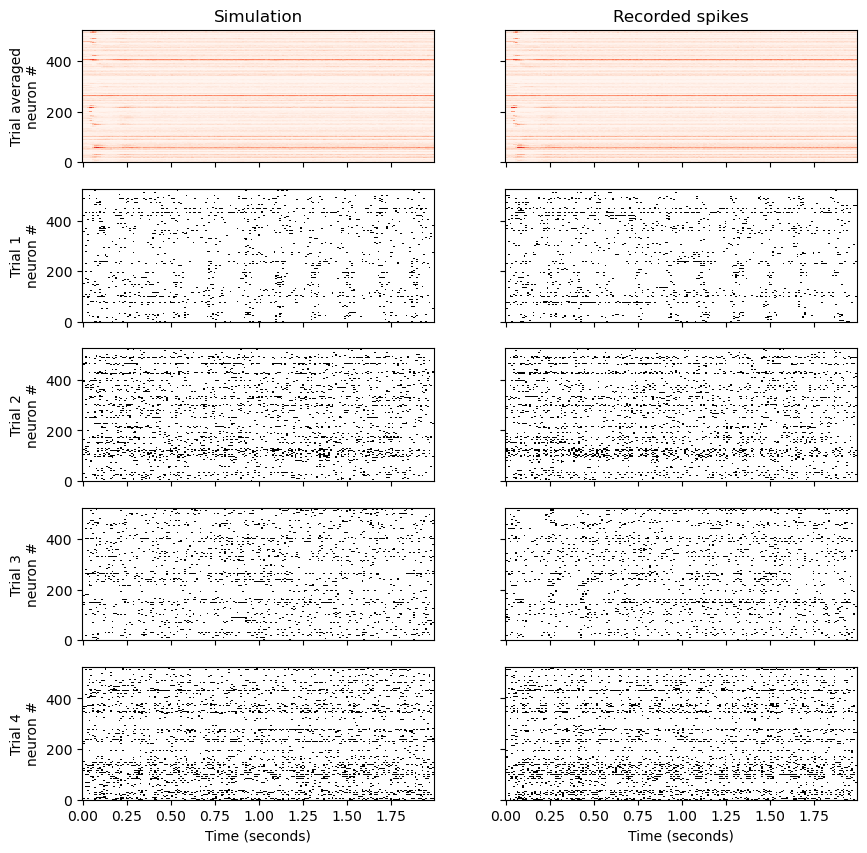

Verified agent code achieves: FD=15.76668440160256


In [24]:
torch.save(trained_vae.state_dict(), "trained_vae.pt")

# Example of submission of the agent here to compete with your peers
# https://ml-arena.com/viewcompetition/20
#
# Submit files
# - train_vae.pt
# - torch_basics.py (download it from the shared folder /shared/DLN-2025W/notebook-2/utils
# - agent.py file with the following:
#
# In the agent.py of the competition: 
# 1) Import stuff (torch, numpy, torch_basics) and constants
# 2) Define your constants (T=200, N=525, d_latent=4, d_net=?? ...)
# 3) Copy-paste your VAE class from the notebook cell above with related classes (ResLstm, Vec2Spikes, VAE)
# 4) Copy-paste the Agent class below to git the agent class API of the competition
class Agent:
    def __init__(self,):
        self.vae = VAE(d_net=d_net, d_latent=d_latent)
        self.vae.load_state_dict(torch.load("trained_vae.pt", weights_only=False, map_location=torch.device("cpu")))
        self.vae.eval()

    def encode(self, X : np.ndarray):
        z = torch.tensor(X, dtype=torch.float) # device is cpu device
        mu, logvar = self.vae.encode(z)
        return mu.detach().cpu().numpy()

    def decode(self, z : np.ndarray):
        latent = torch.tensor(z, dtype=torch.float)
        logits =  self.vae.decode(latent)
        spikes = (torch.sigmoid(logits) > torch.rand_like(logits)).float()
        return spikes.detach().cpu().numpy()

# That's it. The small code below is a quick test to verify the agent class:
competitionAgent = Agent()
latent_agent = competitionAgent.encode(z_train)
z_recon_agent = competitionAgent.decode(latent_agent)

FD_agent = frechenet_distance(torch.tensor(z_recon_agent), z_test_tensor, batch_size, normalized_feature_fun)

plot_raster_plots(z_recon_agent, z_train_tensor, k_plot_trials = 4)
print(f"Verified agent code achieves: FD={FD_agent}")
        

# BONUS Part 2 - Combining VAE and Spiking RNN

An open question in computational neuroscience is whether biophysical modeling can be combined with deep learning for interesting scientific discovery.
We will try to build a strong generative model of neural activity (high R2, and low FD) which combines VAE and Spiking RNN.

In [25]:
def triangular_spike_function(u, dampening_factor=0.3):
    dz = (1- torch.abs(u)) * dampening_factor # triangle around threshold crossing u~0
    z_backward = u * dz
    z_forward = (u > 0).float()
    z = (z_forward - z_backward).detach() + z_backward
    return z

def sigmoid_spike_function(u):
    z_diff = F.sigmoid(u)
    z_disc = (torch.rand_like(u) < z_diff).float()
    z = (z_disc - z_diff).detach() + z_diff
    return z


class AutoregressiveSpikingRNN(nn.Module):

    def __init__(self, N, n_history,):
        super().__init__()
        self.N = N
        self.n_history = n_history

        #self.weight_matrix = LowRankWeightMatrix2(N, N, 20)

        self._w_rec = nn.Parameter(torch.randn(N, N) / np.sqrt(N))
        self.bn_inputs = MyBatchNorm1d(N)
        self._history_filter = nn.Parameter(- torch.rand((N, 1, n_history)) / n_history)

        self.dropout = nn.Dropout(p=0.2)
        self.scalar_rec = MyScaler(N) #
        self.scalar_hist = MyScaler(N) #
        self.scalar_zero_state = MyScaler(N)

    def spike_function(self, u):
        return sigmoid_spike_function(u)

    def zero_state_buffer(self, B, device):
        zero_state_seed = torch.zeros((B, self.n_history, N),device=device) # deterministic version
        return F.sigmoid(self.scalar_zero_state(zero_state_seed))

    def w_rec(self):
        w = self._w_rec
        w = w - torch.diag(torch.diag(w))
        return w

    def history_filter(self):
        return self._history_filter

    def forward(self, u_latent, z_target, zero_state_buffer=None):
        B, T, N = z_target.shape

        if zero_state_buffer is None:
            zero_state_buffer = self.zero_state_buffer(B, u_latent.device)

        z_padded = torch.cat([zero_state_buffer, z_target[:,:-1]], dim=1)

        # TODO: Implement the `u_rec` and `u_history` as function of z_padded, self.w_rec(), and self.history_filter()
            
        # YOUR CODE HERE
        raise NotImplementedError()

        assert u_rec.shape == u_history.shape, f"u_rec={u_rec.shape}, u_history={u_history.shape}"
        assert u_latent.shape == u_rec.shape, f"u_rec={u_rec.shape}, u_latent={u_latent.shape}"

        # scaling
        u_rec = self.scalar_rec(u_rec)
        u_history = self.scalar_hist(u_history)

        u = u_rec + u_history + u_latent
        z = self.spike_function(u)
        assert z_target.shape == z.shape, f"z={z.shape}, z_target={z_target.shape}"
        return z, u

    def generate(self, latent, zero_state_buffer=None):
        B, T, N = latent.shape

        if zero_state_buffer is None:
            zero_state_buffer = self.zero_state_buffer(B, device=latent.device) #, torch.zeros((B, self.n_history, N), device=latent.device) #.detach()

        # initialize the loop
        z_buffer = zero_state_buffer
        z = z_buffer[:,-1]

        logits = []
        zs = []

        for t in range(T):

            # TODO: Implement the `u_rec` and `u_history` as function of z, z_buffer, self.w_rec(), and self.history_filter()
            
            # YOUR CODE HERE
            raise NotImplementedError()

            # scaling
            u_rec = self.scalar_rec(u_rec)
            u_history = self.scalar_hist(u_history)

            u = latent[:,t] + u_rec + u_history
            if torch.any(torch.isnan(z)): raise ValueError(f"t={t} and z=NaN z={torch.isnan(u_rec).any()} z_target={torch.isnan(u_history).any()} ", )
            if torch.any(torch.isnan(u)): raise ValueError(f"t={t} and NaN", )
            z = self.spike_function(u)

            # roll the spike buffer
            z_buffer = torch.cat([z_buffer[:,1:], z[:,None]], 1) #.detach() # detach history buffer to avoid memory scaling ?

            zs.append(z)
            logits.append(u)

        zs = torch.stack(zs, 1)
        logits = torch.stack(logits, 1)
        return zs, logits

    def test_consistency(self, latent):
        was_training = self.training
        self.eval()

        zero_state_buffer = self.zero_state_buffer(latent.shape[0], device=latent.device)

        z, logits = self.generate(latent, zero_state_buffer=zero_state_buffer)
        z_forward, logits_forward = self.forward(latent, z, zero_state_buffer=zero_state_buffer)

        numerical_error = (logits - logits_forward).abs() / (logits.abs() + logits_forward.abs()).clip(min=1e-6)

        assert numerical_error.max() < 1e-2, f"numerical error={numerical_error.max().item():0.08f} at {np.unravel_index(numerical_error.argmax(), numerical_error.shape)}"

        print(f"Passed test with numerical error={numerical_error.max().item():0.08f} ")

        if was_training: self.train()
        return z, logits

d_latent, n_history = 3, 10
#latent_encoder = LatentEncoder(d_latent, N)
rnn = AutoregressiveSpikingRNN(N, n_history)
rnn.eval()
#latent = torch.randn(5, d_latent)
u_latent = torch.randn(5, 20, rnn.N) #latent_encoder(latent, 5, 25)
z, logits = rnn.test_consistency(u_latent)

NotImplementedError: 

In [ ]:
from time import time
from utils.writer import SimpleWriter
writer = SimpleWriter()

# build RNN and run it:
batch_size = 128
d_latent = 4
n_history = 10

# TODO: d_net ?

# YOUR CODE HERE
raise NotImplementedError()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rnn = AutoregressiveSpikingRNN(N, n_history)
vae2 = VAE(d_net=d_net, d_latent=d_latent)
models = [rnn, vae2]

params = []
for m in models:
    params += list(m.parameters())
    m.to(device)

#discriminator = RasterDiscriminator(N)
optimizer = torch.optim.AdamW(params, lr)
print(f"device={device}")

get_float = lambda f: f.item() if isinstance(f, torch.Tensor) else f
update_ema = lambda new_val, ema : get_float(new_val) if ema is None else 0.99 * ema + 0.01 * get_float(new_val)

iter = 0
for epoch in range(num_epoch):
    for m in models: m.train()
    permutation = torch.randperm(z_train.shape[0])

    if epoch < 3:
        modify_optimizer_lr(optimizer, lr / 10**(3 - epoch))
    else:
        modify_optimizer_lr(optimizer, lr)

    num_batch_per_epoch = z_train_tensor.shape[0] // batch_size
    for i_batch in range(num_batch_per_epoch):
        i_start = i_batch * batch_size

        iter += 1
        t0 = time()
        optimizer.zero_grad()
        z_train_batch = z_train_tensor[permutation[i_start:i_start+batch_size]]
        cond_inds = label_train[permutation[i_start:i_start+batch_size]].to(device)
        run_inds = label_run_train[permutation[i_start:i_start+batch_size]].to(device)

        u_latent, latent, loss_dkl = vae2(z_train_batch, 0, T)
        z_simu_train, logits = rnn.forward(u_latent, z_train_batch)
        loss_MLE = spike_loss(logits, z_train_batch)

        do_print = i_batch == num_batch_per_epoch-1 and (epoch % 50 == 0)
        
        if do_print or np.random.rand() > 0.1:
            n_steps = 200 if do_print else [25, 50, 100, 200][np.random.randint(4)]
            t_start = np.random.randint(0, T-n_steps) if n_steps < T else 0
            t_end = t_start + n_steps
            zero_state_buffer = z_train_batch[:,t_start - n_history:t_start] if t_start > n_history else rnn.zero_state_buffer(batch_size, device=device)

            z_simu_train, logits = rnn.generate(u_latent, zero_state_buffer=zero_state_buffer)
            loss_psth, _ = fun_psth_metrics(z_simu_train, z_train_batch, batch_size)
            loss_MLE_free = spike_loss(logits, z_train_batch)

            # Sometimes run psth MSE to stabilize learning, sometimes run (free) binary cross entropy which is much harder?
            #loss_psth.backward() if np.random.rand() > 0.5 else loss_MLE_free.backward()
            loss_MLE_free.backward()
        else:
            # We do not run generate as every training step because forward is a log faster than generate
            (loss_MLE + beta_VAE_coeff * loss_dkl).backward()

        optimizer.step()

    # testing:
    if do_print:
        with torch.no_grad():
            vae.eval()

            t0 = time()
            u_latent, latent, loss_dkl_test = vae2(z_test_tensor, 0, T)
            u_latent_gen = vae2.decode(torch.randn((batch_size, d_latent), device=latent.device))
            
            z_simu_test, logits = rnn.generate(u_latent)
            z_gen, logits = rnn.generate(u_latent_gen)
            
            loss_MLE_test = spike_loss(u_latent, z_test_tensor)
            loss_MLE_free_test = spike_loss(logits, z_test_tensor)

            if torch.isnan(z_simu_test).any(): raise ValueError(f"epoch={epoch} has NaN")

            _, corr_train = fun_psth_metrics(z_simu_train, z_train_tensor, batch_size, random_sample=True)
            _, corr_test = fun_psth_metrics(z_simu_test, z_test_tensor, batch_size, random_sample=True)
            _, corr_gen = fun_psth_metrics(z_gen, z_test_tensor, batch_size, random_sample=True)
            
            R2_train, *_ = fun_trial_matched_metrics(z_simu_train, z_train_tensor, batch_size, normalized_feature_fun, already_matched=True)
            R2_test, *_ = fun_trial_matched_metrics(z_simu_test, z_test_tensor, batch_size, normalized_feature_fun, already_matched=True)
            R2_gen, *_ = fun_trial_matched_metrics(z_simu_gen, z_test_tensor, batch_size, normalized_feature_fun, already_matched=False)
            
            FD_train = frechenet_distance(z_simu_train, z_train_tensor, batch_size, normalized_feature_fun)
            FD_test = frechenet_distance(z_simu_test, z_test_tensor, batch_size, normalized_feature_fun)
            FD_gen = frechenet_distance(z_gen, z_test_tensor, batch_size, normalized_feature_fun)

            if epoch > 50:
                writer.add_scalar("loss_recon", loss_MLE.item(), epoch)
                writer.add_scalar("loss_recon_test", loss_MLE_test.item(), epoch)
                writer.add_scalar("loss_dlk", loss_dkl.item(), epoch)
                writer.add_scalar("loss_dkl_test", loss_dkl_test.item(), epoch)
                writer.add_scalar("corr_train", corr_train, epoch)
                writer.add_scalar("corr_test", corr_test, epoch)
                writer.add_scalar("corr_gen", corr_gen, epoch)
                writer.add_scalar("R2_train", R2_train, epoch)
                writer.add_scalar("R2_test", R2_test, epoch)
                writer.add_scalar("R2_gen", R2_gen, epoch)
                writer.add_scalar("FD_train", FD_train, epoch)
                writer.add_scalar("FD_test", FD_test, epoch)
                writer.add_scalar("FD_gen", FD_gen, epoch)


            fr_simu_train = z_simu_test.mean((0,1))
            fr_train = z_train_tensor.mean((0,1))
            fr_test = z_test_tensor.mean((0,1))
            s = ""
            for i in range(3): s+= f" \t {fr_simu_train[i] / dataset.dt:0.1f} / {fr_train[i] / dataset.dt:0.1f} / {fr_test[i] / dataset.dt:0.1f}"


            print(f"epoch={epoch} ")
            print("\t Single neuron firing rates simu/train/test (Hz): \n\t", s)
            print(f"\t Losses: train/test \n\t\t dkl={loss_dkl.item():0.3f}/{loss_dkl_test.item():0.3f} MLE={loss_MLE.item():0.3f}/{loss_MLE_test:0.3f}"
                  f"\n\t Metrics: train/test/gen:  \n\t\t PSTH corr={corr_train:0.3f}/{corr_test:0.3f}/{corr_gen:0.3f} (ref={corr_psth_ref:0.3f})"
                  f"\t R2={R2_train:0.2f}/{R2_test:0.2f}/{R2_gen:0.2f} (ref={R2_ref:0.2f}) "
                  f"\t FD={FD_train:0.2f}/{FD_test:0.2f}/{FD_gen:0.2f} (ref={FD_ref:0.2f})"
                  )

            if epoch % 1000 == 0 or epoch == num_epoch -1:
                #plot_raster_plots(z_simu_train, z_train, k_plot_trials=2)
                plot_raster_plots(z_simu_test, z_test, k_plot_trials=2)
                plot_latent(latent, label_test, label_run_test)

                if epoch > 0:
                    writer.make_plots([["loss_dkl", "loss_dkl_test"], ["loss_recon", "loss_recon_test"],
                                       ["corr_train", "corr_test", "corr_gen"], ["R2_train", "R2_test", "R2_gen"], ["FD_train", "FD_test", "FD_gen"]],
                                  1 if epoch < 100 else 10, figsize=((8, 8)))

                plt.show()

In [ ]:
def plot_weight_matrix_per_area(rnn):
    w = to_numpy(rnn.w_rec())

    na = len(selected_areas)
    w_summary = np.zeros((na, na))
    for iA, area_i in enumerate(selected_areas):
        for jA, area_j in enumerate(selected_areas):
            ind_i = dataset.get_neuron_indices_for_area(area_i)
            ind_j = dataset.get_neuron_indices_for_area(area_j)
            w_summary[iA,jA] = w[ind_i,:][:,ind_j].mean()

    w_val = np.abs(w_summary).max()
    plt.pcolor(w_summary, vmin=-w_val, vmax=w_val, cmap="seismic")
    plt.xticks(np.arange(na)+0.5, selected_areas)
    plt.yticks(np.arange(na)+0.5, selected_areas)
    plt.xlabel("target")
    plt.ylabel("source")
    plt.colorbar()
    plt.show()

    history_filter = to_numpy(rnn.history_filter()).squeeze()

    time_line = - np.arange(history_filter.shape[-1])[::-1] * dataset.dt
    plt.plot(time_line, history_filter.mean(0), lw=3, color="blue")
    plt.show()

plot_weight_matrix_per_area(rnn)